In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

import sys

sys.path.append("../../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "1,2,3,4,5,6,7"
##################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

2025-09-16 11:27:32 __main__ INFO     torch.__version__='2.7.0+cu126', torch.version.cuda='12.6'
2025-09-16 11:27:32 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=7, torch.cuda.get_device_name()='NVIDIA A100 80GB PCIe'
2025-09-16 11:27:32 __main__ INFO     transformers.__version__='4.55.3'


In [3]:
from src.utils.training_utils import get_device_map

# model_key = "meta-llama/Llama-3.2-3B"
# model_key = "meta-llama/Llama-3.1-8B"
# model_key = "meta-llama/Llama-3.1-70B-Instruct"
model_key = "meta-llama/Llama-3.3-70B-Instruct"
# model_key = "meta-llama/Llama-3.1-405B-Instruct"

# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-3-12b-it"
# model_key = "google/gemma-2-27b-it"

# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

# model_key = "Qwen/Qwen2-7B"
# model_key = "Qwen/Qwen2.5-14B-Instruct"
# model_key = "Qwen/Qwen2.5-32B-Instruct"
# model_key = "Qwen/Qwen2.5-72B-Instruct"

# model_key = "Qwen/Qwen3-1.7B"
# model_key = "Qwen/Qwen3-4B"
# model_key = "Qwen/Qwen3-8B"
# model_key = "Qwen/Qwen3-14B"
# model_key = "Qwen/Qwen3-32B"

# device_map = get_device_map(model_key, 30, n_gpus=8)
# device_map

2025-09-16 11:27:36 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks/checking_predicate_generalization, stdin=None, shell=False, universal_newlines=False)
2025-09-16 11:27:36 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks/checking_predicate_generalization, stdin=None, shell=False, universal_newlines=False)
2025-09-16 11:27:36 wandb.docker.auth DEBUG    Trying paths: ['/disk/u/arnab/.docker/config.json', '/disk/u/arnab/.dockercfg']
2025-09-16 11:27:36 wandb.docker.auth DEBUG    No config file found


In [4]:
from src.models import ModelandTokenizer

# from transformers import BitsAndBytesConfig

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # device_map=device_map,
    device_map="auto",
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
    attn_implementation="eager",
)

2025-09-16 11:27:37 src.models WARNING  meta-llama/Llama-3.3-70B-Instruct not found in /disk/u/arnab/Codes/Models
If not found in cache, model will be downloaded from HuggingFace to cache directory
2025-09-16 11:27:37 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443


2025-09-16 11:27:37 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/config.json HTTP/1.1" 200 0
2025-09-16 11:27:37 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2025-09-16 11:27:37 urllib3.connectionpool DEBUG    https://huggingface.co:443 "GET /api/models/meta-llama/Llama-3.3-70B-Instruct/tree/main/additional_chat_templates?recursive=False&expand=False HTTP/1.1" 404 64


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

2025-09-16 11:28:26 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/generation_config.json HTTP/1.1" 200 0
2025-09-16 11:28:27 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/custom_generate/generate.py HTTP/1.1" 404 0
2025-09-16 11:28:27 src.models INFO     loaded model <meta-llama/Llama-3.3-70B-Instruct> | size: 134570.516 MB | dtype: torch.bfloat16 | device: cuda:0


In [18]:
from src.selection.data import SelectOneTask, CountingTask

#################################################################################
TASK_CLS = SelectOneTask
prompt_template_idx = 3
N_DISTRACTORS = 5
OPTION_STYLE = "single_line"
#################################################################################

source_task = TASK_CLS.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        # "profession.json"
        # "nationality.json"
        "objects.json"
    )
)

print(source_task)

['name', 'prompt_templates', 'odd_one_prompt_templates', 'order_prompt_templates', 'count_prompt_templates', 'yes_no_prompt_templates', 'first_item_in_cat_prompt_templates', 'last_item_in_cat_prompt_templates', 'categories', 'exclude_categories']
SelectOneTask: (different objects)
Categories: fruit(15), vehicle(15), furniture(15), animal(15), music instrument(15), clothing(15), electronics(15), sport equipment(15), kitchen appliance(15), vegetable(14), building(15), office supply(15), bathroom item(15), flower(15), tree(15), jewelry(15)



In [19]:
sample = source_task.get_random_sample(
    mt = mt,
    option_style=OPTION_STYLE,
    prompt_template_idx=prompt_template_idx,
    # category="actor",
    # category="Brazil"
    category="fruit",
    filter_by_lm_prediction=False,
)

print(sample.prompt(), ">>", f'"{mt.tokenizer.decode([sample.ans_token_id])}"')

Options: Accordion, Blueberry, Giraffe, Stool, Charm, Phone.
Which among these objects mentioned above is a fruit?
Answer: >> " Blue"


In [20]:
sample.default_option_style = "bulleted"
print(sample.prompt(), ">>", f'"{mt.tokenizer.decode([sample.ans_token_id])}"')

* Accordion
* Blueberry
* Giraffe
* Stool
* Charm
* Phone
Which among these objects mentioned above is a fruit?
Answer: >> " Blue"


## Loading the heads

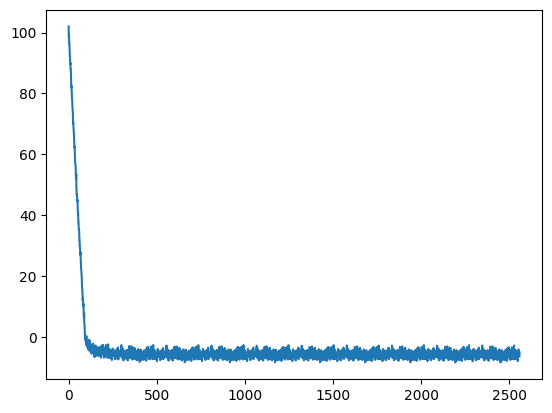

In [21]:
from matplotlib import pyplot as plt
import numpy as np

# optimized_path = os.path.join(
#     env_utils.DEFAULT_RESULTS_DIR,
#     "selection/optimized_backup_heads",
#     mt.name.split("/")[-1],
#     f"{select_task.task_name}.npz"
# )

optimized_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/optimized_heads",
    model_key.split("/")[-1],
    "distinct_options",
    f"{source_task.task_name}",
    # "legacy",
    "epoch_10.npz"
)

# optimized_path = os.path.join(
#     env_utils.DEFAULT_RESULTS_DIR,
#     "test_opt_code",
#     model_key.split("/")[-1],
#     "distinct_options",
#     f"{select_task.task_name}",
#     # "select_one",
#     "legacy",
#     "epoch_10.npz"
# )

optimization_results = np.load(optimized_path, allow_pickle=True)
plt.plot(optimization_results["losses"])
plt.show()

79


(True, True)

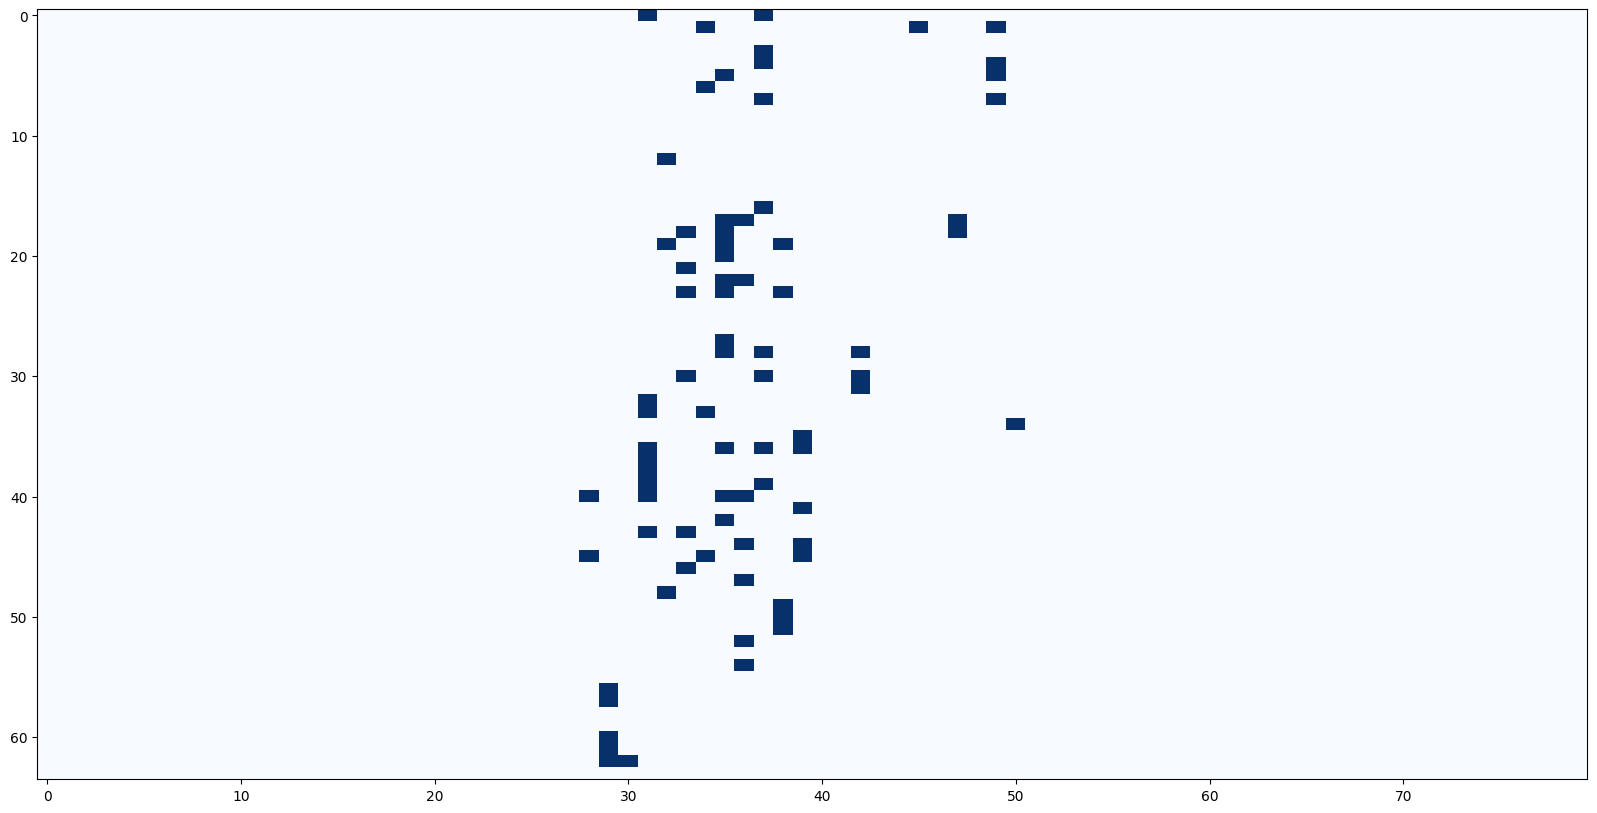

In [22]:
plt.figure(figsize=(20, 10))

optimal_head_mask = torch.tensor(optimization_results["optimal_mask"]).to(torch.float32)
optimal_head_mask[52:, :] = 0.0

plt.imshow(
    optimal_head_mask.T.numpy(),
    cmap="Blues",
    aspect="auto",
    vmin=0,
    vmax=1,
)

optimized_heads = torch.nonzero(optimal_head_mask > 0.5, as_tuple=False).tolist()
optimized_heads = [
    (layer_idx, head_idx) for layer_idx, head_idx in optimized_heads
]
print(len(optimized_heads))

HEADS = optimized_heads

(35, 19) in HEADS, (35, 19) in optimized_heads
# [(29, 3) in HEADS]

In [23]:
from src.attention import get_attention_matrices
from src.selection.functional import (
    verify_head_patterns,
    get_patches_to_verify_independent_enrichment,
)

attn_pattern = verify_head_patterns(
    prompt=sample.prompt(option_style="single_line"),
    options=sample.options,
    mt=mt,
    heads=optimized_heads,
    # heads = HEADS,
    # heads = [(35, 19)],
    start_from=1
)

2025-09-16 11:32:07 src.selection.functional DEBUG    Predictions: ['" Blue"[8868] (p=0.793, logit=22.125)', '" The"[578] (p=0.107, logit=20.125)', '" Among"[22395] (p=0.051, logit=19.375)', '" A"[362] (p=0.011, logit=17.875)', '" blue"[6437] (p=0.003, logit=16.625)']
2025-09-16 11:32:07 src.selection.functional INFO     Combined attention matrix for all heads


## Checking the effect of formatting

In [13]:
from src.selection.data import get_counterfactual_samples_within_task

clean_sample, patch_sample = get_counterfactual_samples_within_task(
    task=source_task,
    mt=mt,
    patch_category="fruit",
    clean_category="vehicle",
    distinct_options=True,
    n_distractors=5,
    filter_by_lm_prediction=False,
)

clean_sample.default_option_style = "bulleted"
patch_sample.default_option_style = "single_line"

assert clean_sample.default_option_style != patch_sample.default_option_style

print(
    "CLEAN:",
    clean_sample.prompt(),
    ">>",
    f'"{mt.tokenizer.decode([clean_sample.ans_token_id])}"',
)
print(
    "PATCH:",
    patch_sample.prompt(),
    ">>",
    f'"{mt.tokenizer.decode([patch_sample.ans_token_id])}"',
)

2025-09-16 11:29:24 src.selection.data INFO     clean_obj_idx=4 | ['Kiwi', 'Sofa', 'Carrot', 'Tiara', 'Yacht', 'Folder']


type(task)=<class 'src.selection.data.SelectOneTask'>
CLEAN: * Toilet paper
* Cherry
* Surfboard
* Cello
* Bike
* Orchid
Which among these objects mentioned above is a fruit?
Answer: >> " Cherry"
PATCH: Options: Kiwi, Sofa, Carrot, Tiara, Yacht, Folder.
Which among these objects mentioned above is a vehicle?
Answer: >> " Y"


In [10]:
source_task.categories

['fruit',
 'vehicle',
 'furniture',
 'animal',
 'music instrument',
 'clothing',
 'electronics',
 'sport equipment',
 'kitchen appliance',
 'vegetable',
 'building',
 'office supply',
 'bathroom item',
 'flower',
 'tree',
 'jewelry']

# Validating Against Other Reduce Tasks

In [166]:
import random
from src.selection.data import get_counterfactual_samples_interface
from src.selection.data import YesNoTask, SelectFirstTask, CountingTask, SelectLastTask
from typing import Optional
import copy
from src.tokens import prepare_input
from src.selection.utils import verify_correct_option
from src.selection.data import get_options_for_answer


def get_task_specific_kwargs(task, distinct_options=True):
    kwargs = {}
    if isinstance(task, CountingTask):
        kwargs["clean_n_options"] = random.choice(range(4, 7))
        kwargs["patch_n_options"] = random.choice(range(4, 7))
        kwargs["distinct_options"] = distinct_options
    elif isinstance(task, YesNoTask):
        kwargs["clean_n_options"] = random.choice(range(3, 6))
        kwargs["patch_n_options"] = random.choice(range(3, 6))
        # No distinct options for yes/no task
    elif isinstance(task, SelectFirstTask | SelectLastTask):
        #! this has to come before SelectOneTask since SelectFirstTask is a subclass of SelectOneTask
        kwargs["distinct_options"] = distinct_options
        kwargs["n_distractors"] = random.choice(range(3, 6))
    elif isinstance(task, SelectOneTask):
        kwargs["distinct_options"] = distinct_options
        kwargs["patch_n_distractors"] = random.choice(range(2, 7))
        kwargs["clean_n_distractors"] = random.choice(range(2, 7))
    return kwargs


def get_counterfactual_samples_across_tasks(
    mt: ModelandTokenizer,
    patch_task,
    clean_task,
    patch_category: str | None = None,
    clean_category: str | None = None,
    patch_prompt_template_idx: int = 3,
    clean_prompt_template_idx: int = 3,
    clean_transform: Optional[callable] = None,
    patch_transform: Optional[callable] = None,
    filter_by_lm_prediction=False,
    retry_count=0,
):
    categories = patch_task.categories
    for category in clean_task.categories:
        assert category in categories, "Categories must be the same!"

    patch_category = patch_category or random.choice(categories)
    clean_category = clean_category or random.choice(
        list(set(categories) - {patch_category})
    )

    assert patch_category != clean_category, "Categories must be different!"

    patch_sample, _ = get_counterfactual_samples_interface[patch_task.task_name](
        mt=mt,
        task=patch_task,
        patch_category=patch_category,
        clean_category=clean_category,
        prompt_template_idx=patch_prompt_template_idx,
        filter_by_lm_prediction=False,
        **get_task_specific_kwargs(patch_task, distinct_options=True),
    )

    _, clean_sample = get_counterfactual_samples_interface[clean_task.task_name](
        mt=mt,
        task=clean_task,
        patch_category=patch_category,
        clean_category=clean_category,
        prompt_template_idx=clean_prompt_template_idx,
        filter_by_lm_prediction=False,
        **get_task_specific_kwargs(clean_task, distinct_options=True),
    )

    if patch_transform is not None:
        patch_sample = patch_transform(patch_sample)
    if clean_transform is not None:
        clean_sample = clean_transform(clean_sample)

    if "qwen" in mt.name.lower():
        # for attention sink
        clean_sample.prompt_template = (
            "# " + clean_sample.prompt_template
            if not clean_sample.prompt_template.startswith("#")
            else clean_sample.prompt_template
        )
        patch_sample.prompt_template = (
            "# " + patch_sample.prompt_template
            if not patch_sample.prompt_template.startswith("#")
            else patch_sample.prompt_template
        )

    if filter_by_lm_prediction:
        test_samples = [patch_sample, clean_sample]
        gold_sample = copy.deepcopy(clean_sample)
        gold_sample.category = clean_sample.metadata["track_category"]
        gold_sample.ans_token_id = clean_sample.metadata["track_type_obj_token_id"]
        test_samples.append(gold_sample)

        for sample in test_samples:
            prompt = sample.prompt()
            tokenized_inputs = prepare_input(prompts=prompt, tokenizer=mt.tokenizer)
            sample.metadata["tokenized"] = tokenized_inputs.data

            print("-" * 80)
            print(sample.prompt(), ">>", mt.tokenizer.decode(sample.ans_token_id))

            is_correct, predictions, track_options = verify_correct_option(
                mt=mt,
                input=tokenized_inputs,
                target=sample.ans_token_id,
                options=get_options_for_answer(sample),
            )

            if is_correct is False:
                logger.error(
                    f'Prediction mismatch: {track_options[list(track_options.keys())[0]]}["{mt.tokenizer.decode(predictions[0].token_id)}"] != {sample.ans_token_id}["{mt.tokenizer.decode(sample.ans_token_id)}"]'
                )
                # for debugging
                if retry_count > 20:
                    raise ValueError(f"Max retries ({retry_count}) exceeded!")

                return get_counterfactual_samples_across_tasks(
                    mt=mt,
                    patch_task=patch_task,
                    clean_task=clean_task,
                    patch_category=patch_category,
                    clean_category=clean_category,
                    patch_prompt_template_idx=patch_prompt_template_idx,
                    clean_prompt_template_idx=clean_prompt_template_idx,
                    clean_transform=clean_transform,
                    patch_transform=patch_transform,
                    filter_by_lm_prediction=filter_by_lm_prediction,
                    retry_count=retry_count + 1,
                )

    return patch_sample, clean_sample

### Select One -- MCQ

In [62]:
from src.selection.data import SelectionSample, SelectOneTask

select_one_mcq = SelectOneTask.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        "objects.json"
        # "profession.json"
        # "nationality.json"
        # "landmarks.json"
    )
)
print(select_one_mcq)

['name', 'prompt_templates', 'odd_one_prompt_templates', 'order_prompt_templates', 'count_prompt_templates', 'yes_no_prompt_templates', 'first_item_in_cat_prompt_templates', 'last_item_in_cat_prompt_templates', 'categories', 'exclude_categories']
SelectOneTask: (different objects)
Categories: fruit(15), vehicle(15), furniture(15), animal(15), music instrument(15), clothing(15), electronics(15), sport equipment(15), kitchen appliance(15), vegetable(14), building(15), office supply(15), bathroom item(15), flower(15), tree(15), jewelry(15)



In [63]:
import copy
from src.selection.utils import get_first_token_id
from src.functional import predict_next_token
from src.selection.data import MCQify_sample

test_sample = select_one_mcq.get_random_sample(
    mt=mt,
    option_style=OPTION_STYLE,
    prompt_template_idx=3,
    category="fruit",
    # category="actor",
    # category="United Kingdom",
    filter_by_lm_prediction=True,
)

test_sample = MCQify_sample(mt, test_sample)
print(
    test_sample.prompt(), ">>", f'"{mt.tokenizer.decode([test_sample.ans_token_id])}"'
)

predict_next_token(mt=mt, inputs=test_sample.prompt())

a. Coffee table
b. Mango
c. Blender
d. Shower
e. Earring
f. School
Which among these objects mentioned above is a fruit?
Answer: >> " b"


[[PredictedToken(token=' b', prob=0.56640625, logit=21.5, token_id=293, metadata=None),
  PredictedToken(token=' Mango', prob=0.2080078125, logit=20.5, token_id=91963, metadata=None),
  PredictedToken(token=' (', prob=0.142578125, logit=20.125, token_id=320, metadata=None),
  PredictedToken(token=' The', prob=0.02197265625, logit=18.25, token_id=578, metadata=None),
  PredictedToken(token=' Option', prob=0.0194091796875, logit=18.125, token_id=7104, metadata=None)]]

In [64]:
def mcq_transform(sample):
    sample = MCQify_sample(mt=mt, sample=sample)
    if "track_type_obj_token_id" in sample.metadata:
        patch_obj_idx = sample.metadata["track_type_obj_idx"]
        sample.metadata["track_type_obj_token_id"] = get_first_token_id(
            name=chr(ord("a") + patch_obj_idx), tokenizer=mt.tokenizer, prefix=" "
        )
    return sample


patch_sample, clean_sample = get_counterfactual_samples_across_tasks(
    mt=mt,
    patch_task=source_task,
    clean_task=select_one_mcq,
    patch_category="fruit",
    clean_category="vehicle",
    clean_transform=mcq_transform,
    filter_by_lm_prediction=True
)

print(
    "CLEAN:",
    clean_sample.prompt(),
    ">>",
    f'"{mt.tokenizer.decode([clean_sample.ans_token_id])}"',
)
print(
    "PATCH:",
    patch_sample.prompt(),
    ">>",
    f'"{mt.tokenizer.decode([patch_sample.ans_token_id])}"',
)

2025-09-16 12:04:47 src.selection.data INFO     clean_obj_idx=1 | ['Tape', 'Truck', 'Cherry', 'Rabbit']


type(task)=<class 'src.selection.data.SelectOneTask'>
2025-09-16 12:04:47 src.selection.data INFO     clean_obj_idx=2 | ['Kiwi', 'Iris', 'Bus']
type(task)=<class 'src.selection.data.SelectOneTask'>
--------------------------------------------------------------------------------
Options: Grape, Apartment, Airplane.
Which among these objects mentioned above is a fruit?
Answer: >>  Grape
--------------------------------------------------------------------------------
a. Kiwi
b. Iris
c. Bus
Which among these objects mentioned above is a vehicle?
Answer: >>  c
--------------------------------------------------------------------------------
a. Kiwi
b. Iris
c. Bus
Which among these objects mentioned above is a fruit?
Answer: >>  a
CLEAN: a. Kiwi
b. Iris
c. Bus
Which among these objects mentioned above is a vehicle?
Answer: >> " c"
PATCH: Options: Grape, Apartment, Airplane.
Which among these objects mentioned above is a fruit?
Answer: >> " Grape"


In [65]:
from src.selection.data import CounterFactualSamplePair
from src.functional import free_gpu_cache
from src.selection.data import get_counterfactual_samples_interface
import random

validation_samples_save_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    "samples",
    "predicate_generalization",
    mt.name.split("/")[-1],
    source_task.task_name,
    select_one_mcq.task_name + "_mcq",
    "objects",
)

os.makedirs(validation_samples_save_path, exist_ok=True)


free_gpu_cache()
validation_set = []
validation_limit = 512
start_from = 1

counterfactual_sampler = get_counterfactual_samples_interface[select_one_mcq.task_name]

while len(validation_set) < validation_limit:
    print(f"sample {len(validation_set)+1} / {validation_limit}")
    patch, clean = get_counterfactual_samples_across_tasks(
        mt=mt,
        patch_task=source_task,
        clean_task=select_one_mcq,
        clean_transform=mcq_transform,
        filter_by_lm_prediction=True,
    )
    validation_set.append((clean, patch))
    cf_pair = CounterFactualSamplePair(
        patch_sample=patch,
        clean_sample=clean,
    )
    cf_pair.detensorize()
    with open(
        os.path.join(
            validation_samples_save_path,
            f"{len(validation_set) + start_from - 1:05d}.json",
        ),
        "w",
    ) as f:
        json.dump(cf_pair.to_dict(), f, indent=2)

len(validation_set)

sample 1 / 512
2025-09-16 12:04:53 src.selection.data INFO     clean_obj_idx=2 | ['Apple', 'Jeans', 'Tennis ball', 'Trumpet', 'Projector', 'Lotion', 'Mixer']
type(task)=<class 'src.selection.data.SelectOneTask'>
2025-09-16 12:04:53 src.selection.data INFO     clean_obj_idx=0 | ['Dumbbell', 'Guitar', 'Ottoman', 'Pine', 'Museum']
type(task)=<class 'src.selection.data.SelectOneTask'>
--------------------------------------------------------------------------------
Options: Mirror, Golf ball, Sunflower, Blueberry, Harp, Giraffe.
Which among these objects mentioned above is a music instrument?
Answer: >>  Har
--------------------------------------------------------------------------------
a. Dumbbell
b. Guitar
c. Ottoman
d. Pine
e. Museum
Which among these objects mentioned above is a sport equipment?
Answer: >>  a
--------------------------------------------------------------------------------
a. Dumbbell
b. Guitar
c. Ottoman
d. Pine
e. Museum
Which among these objects mentioned above is a 

512

In [72]:
from src.selection.data import CounterFactualSamplePair
import random

validation_set = []
validation_limit = 512

validation_samples_load_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    "samples",
    "predicate_generalization",
    mt.name.split("/")[-1],
    source_task.task_name,
    select_one_mcq.task_name + "_mcq",
    "objects",
)

sample_files = [
    os.path.join(validation_samples_load_path, f)
    for f in os.listdir(validation_samples_load_path)
    if f.endswith(".json")
]
logger.info(f"Found {len(sample_files)} sample files")

prefix = ""
# prefix = "Recall the nationality of these people:\n"
# prefix = "Recall which country these landmarks are located in:\n"
# prefix = "Think about how these words sound when you say them aloud:\n"

random.shuffle(sample_files)
sample_files = sample_files[:validation_limit]
for sample_file in sample_files:
    with open(sample_file, "r") as f:
        cf_pair_data = json.load(f)
    cf_pair = CounterFactualSamplePair.from_dict(cf_pair_data)

    cf_pair.clean_sample.prompt_template = prefix + cf_pair.clean_sample.prompt_template
    cf_pair.patch_sample.prompt_template = prefix + cf_pair.patch_sample.prompt_template
    validation_set.append((cf_pair.clean_sample, cf_pair.patch_sample))

len(validation_set)

2025-09-16 12:27:40 __main__ INFO     Found 512 sample files


512

In [73]:
clean, patch = validation_set[3]
print(patch.prompt(), ">>", mt.tokenizer.decode(patch.ans_token_id))
print(clean.prompt(), ">>", mt.tokenizer.decode(clean.ans_token_id))
clean.metadata["track_type_obj_token_id"], mt.tokenizer.decode(clean.metadata["track_type_obj_token_id"])

Options: Helicopter, Harmonica, Wardrobe, Cat, Eucalyptus, Blender.
Which among these objects mentioned above is a furniture?
Answer: >>  Ward
a. Food processor
b. Bookshelf
c. Yoga mat
d. Bike
e. Brooch
f. Shirt
g. Oak
Which among these objects mentioned above is a kitchen appliance?
Answer: >>  a


(293, ' b')

In [74]:
free_gpu_cache()

In [76]:
from src.selection.optimization import validate_q_proj_ie_on_sample_pair
import copy

clean, patch = copy.deepcopy(validation_set[3])

val_sample_result = validate_q_proj_ie_on_sample_pair(
    mt=mt,
    clean_sample=clean,
    patch_sample=patch,
    heads=optimized_heads,
    query_indices={-2: -2, -1: -1},
    add_ques_pos_to_query_indices=True,
    verify_head_behavior_on=-1,
    patch_args={
        "batch_size": len(patch.options),
        "distinct_options": False,
        # "task": select_task,
        # "prompt_template_idx": prompt_template_idx,
        # "option_style": patch.default_option_style,
        # "n_distractors": N_DISTRACTORS,
    },
)

clean_obj = clean.ans_token_id
target_obj = clean.metadata["track_type_obj_token_id"]

logger.debug(f"clean obj: {mt.tokenizer.decode(clean_obj)}")
logger.debug(f"target obj: {mt.tokenizer.decode(target_obj)}")

before_intervention = {
    "clean_rank": val_sample_result["clean_track"][clean_obj][0],
    "clean_logit": val_sample_result["clean_track"][clean_obj][1].logit,
    "target_rank": val_sample_result["clean_track"][target_obj][0],
    "target_logit": val_sample_result["clean_track"][target_obj][1].logit,
}

after_intervention = {
    "clean_rank": val_sample_result["int_track"][clean_obj][0],
    "clean_logit": val_sample_result["int_track"][clean_obj][1].logit,
    "target_rank": val_sample_result["int_track"][target_obj][0],
    "target_logit": val_sample_result["int_track"][target_obj][1].logit,
}

clean_rank_delta = after_intervention["clean_rank"] - before_intervention["clean_rank"]
target_rank_delta = (
    after_intervention["target_rank"] - before_intervention["target_rank"]
)
logger.info(
    f"Clean Prediction Rank Change: {before_intervention['clean_rank']} -> {after_intervention['clean_rank']} | Delta: {clean_rank_delta} "
)
logger.info(
    f"Target Prediction Rank Change: {before_intervention['target_rank']} -> {after_intervention['target_rank']} | Delta: {target_rank_delta} "
)

clean_logit_delta = (
    after_intervention["clean_logit"] - before_intervention["clean_logit"]
)
target_logit_delta = (
    after_intervention["target_logit"] - before_intervention["target_logit"]
)
logger.info(
    f"Clean Prediction Logit Change: {before_intervention['clean_logit']:.4f} -> {after_intervention['clean_logit']:.4f} | Delta: {clean_logit_delta:.4f} "
)
logger.info(
    f"Target Prediction Logit Change: {before_intervention['target_logit']:.4f} -> {after_intervention['target_logit']:.4f} | Delta: {target_logit_delta:.4f} "
)

2025-09-16 12:55:42 src.selection.optimization DEBUG    Sampling 6 patch samples...


2025-09-16 12:55:42 src.selection.optimization DEBUG    torch.Size([6, 34])
2025-09-16 12:55:42 src.selection.optimization INFO     Verifying head behavior...
2025-09-16 12:55:42 src.selection.optimization INFO     Clean Sample >> Ans:  a


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


2025-09-16 12:55:46 src.selection.functional DEBUG    Generated full answer: " a. Food processor
Explanation: A food processor is a kitchen appliance used to perform various tasks such as chopping, slicing, shredding, and mixing"
2025-09-16 12:55:46 src.selection.functional DEBUG    Predictions: ['" a"[264] (p=0.816, logit=23.125)', '" ("[320] (p=0.059, logit=20.500)', '" Food"[12369] (p=0.052, logit=20.375)', '" The"[578] (p=0.028, logit=19.750)', '" A"[362] (p=0.019, logit=19.375)']
2025-09-16 12:55:46 src.selection.functional INFO     Combined attention matrix for all heads


2025-09-16 12:55:46 src.selection.optimization INFO     Patch Sample >> Ans:  Ward


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


2025-09-16 12:55:50 src.selection.functional DEBUG    Generated full answer: " Wardrobe. A wardrobe is a piece of furniture used to store clothes. It is a tall, usually rectangular, cabinet with shelves, drawers, and"
2025-09-16 12:55:50 src.selection.functional DEBUG    Predictions: ['" Ward"[27738] (p=0.848, logit=22.250)', '" The"[578] (p=0.054, logit=19.500)', '" Among"[22395] (p=0.037, logit=19.125)', '" A"[362] (p=0.033, logit=19.000)', '" It"[1102] (p=0.003, logit=16.500)']
2025-09-16 12:55:50 src.selection.functional INFO     Combined attention matrix for all heads


2025-09-16 12:55:50 src.selection.optimization INFO     Caching the query states for the 79 heads
2025-09-16 12:55:51 src.selection.optimization INFO     patch_prediction=['" Ward"[27738] (p=0.848, logit=22.250)', '" The"[578] (p=0.054, logit=19.500)', '" Among"[22395] (p=0.037, logit=19.125)', '" A"[362] (p=0.033, logit=19.000)', '" It"[1102] (p=0.003, logit=16.500)']
2025-09-16 12:55:51 src.selection.optimization INFO     clean run
2025-09-16 12:55:51 src.selection.optimization INFO     clean_prediction=['" a"[264] (p=0.816, logit=23.125)', '" ("[320] (p=0.059, logit=20.500)', '" Food"[12369] (p=0.052, logit=20.375)', '" The"[578] (p=0.028, logit=19.750)', '" A"[362] (p=0.019, logit=19.375)']
2025-09-16 12:55:51 src.selection.optimization INFO     clean_track=OrderedDict([(264, (1, PredictedToken(token=' a', prob=0.81640625, logit=23.125, token_id=264, metadata=None))), (293, (8, PredictedToken(token=' b', prob=0.0013885498046875, logit=16.75, token_id=293, metadata=None))), (272, (1

2025-09-16 12:55:51 src.selection.optimization INFO     int_prediction=['" b"[293] (p=0.672, logit=21.375)', '" ("[320] (p=0.132, logit=19.750)', '" Book"[6017] (p=0.055, logit=18.875)', '" The"[578] (p=0.038, logit=18.500)', '" Among"[22395] (p=0.020, logit=17.875)']
2025-09-16 12:55:51 src.selection.optimization INFO     int_track=OrderedDict([(293, (1, PredictedToken(token=' b', prob=0.671875, logit=21.375, token_id=293, metadata=None))), (384, (9, PredictedToken(token=' e', prob=0.0074462890625, logit=16.875, token_id=384, metadata=None))), (342, (11, PredictedToken(token=' g', prob=0.00311279296875, logit=16.0, token_id=342, metadata=None))), (282, (12, PredictedToken(token=' f', prob=0.0025787353515625, logit=15.8125, token_id=282, metadata=None))), (294, (14, PredictedToken(token=' d', prob=0.0022735595703125, logit=15.6875, token_id=294, metadata=None))), (272, (15, PredictedToken(token=' c', prob=0.00201416015625, logit=15.5625, token_id=272, metadata=None))), (264, (18, Predi

In [77]:
from tqdm.auto import tqdm

validation_results = []

for clean_sample, patch_sample in tqdm(validation_set):
    val_sample_result = validate_q_proj_ie_on_sample_pair(
        mt=mt,
        clean_sample=clean_sample,
        patch_sample=patch_sample,
        heads=optimized_heads,
        query_indices={-2: -2, -1: -1},
        add_ques_pos_to_query_indices=True,
        patch_args={
            "batch_size": len(patch_sample.options),
            "distinct_options": False,
        },
    )
    validation_results.append(val_sample_result)
    print("=" * 80)

  0%|          | 0/512 [00:00<?, ?it/s]

2025-09-16 12:56:14 src.selection.optimization DEBUG    Sampling 6 patch samples...
2025-09-16 12:56:14 src.selection.optimization DEBUG    torch.Size([6, 33])
2025-09-16 12:56:14 src.selection.optimization INFO     Caching the query states for the 79 heads
2025-09-16 12:56:15 src.selection.optimization INFO     patch_prediction=['" Har"[5340] (p=0.750, logit=21.500)', '" The"[578] (p=0.102, logit=19.500)', '" A"[362] (p=0.062, logit=19.000)', '" Among"[22395] (p=0.026, logit=18.125)', '" It"[1102] (p=0.012, logit=17.375)']
2025-09-16 12:56:15 src.selection.optimization INFO     clean run
2025-09-16 12:56:15 src.selection.optimization INFO     clean_prediction=['" a"[264] (p=0.750, logit=22.250)', '" ("[320] (p=0.115, logit=20.375)', '" D"[423] (p=0.054, logit=19.625)', '" The"[578] (p=0.029, logit=19.000)', '" A"[362] (p=0.023, logit=18.750)']
2025-09-16 12:56:15 src.selection.optimization INFO     clean_track=OrderedDict([(264, (1, PredictedToken(token=' a', prob=0.75, logit=22.25, t

In [79]:
before_intervention = []
after_intervention = []

for intervention_result in validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]

    clean_obj = clean_sample.ans_token_id
    target_obj = clean_sample.metadata["track_type_obj_token_id"]

    before_intervention.append({
        "clean_rank": intervention_result["clean_track"][clean_obj][0],
        "clean_logit": intervention_result["clean_track"][clean_obj][1].logit,
        "target_rank": intervention_result["clean_track"][target_obj][0],
        "target_logit": intervention_result["clean_track"][target_obj][1].logit,
    })

    after_intervention.append({
        "clean_rank": intervention_result["int_track"][clean_obj][0],
        "clean_logit": intervention_result["int_track"][clean_obj][1].logit,
        "target_rank": intervention_result["int_track"][target_obj][0],
        "target_logit": intervention_result["int_track"][target_obj][1].logit,
    })

In [80]:
import numpy as np

clean_rank_delta = [
    after["clean_rank"] - before["clean_rank"]
    for before, after in zip(before_intervention, after_intervention)
]
target_rank_delta = [
    after["target_rank"] - before["target_rank"]
    for before, after in zip(before_intervention, after_intervention)
]

clean_rank_delta, target_rank_delta = np.array(clean_rank_delta), np.array(
    target_rank_delta
)
print(f"clean_rank_delta: {clean_rank_delta.mean():.4f} ± {clean_rank_delta.std():.4f}")
print(
    f"target_rank_delta: {target_rank_delta.mean():.4f} ± {target_rank_delta.std():.4f}"
)

clean_rank_after_intervention = [after["clean_rank"] for after in after_intervention]
clean_rank_after_intervention = np.array(clean_rank_after_intervention)
print(
    f"clean_rank_after_intervention: {clean_rank_after_intervention.mean():.4f} ± {clean_rank_after_intervention.std():.4f}"
)

target_rank_after_intervention = [after["target_rank"] for after in after_intervention]
target_rank_after_intervention = np.array(target_rank_after_intervention)
print(
    f"target_rank_after_intervention: {target_rank_after_intervention.mean():.4f} ± {target_rank_after_intervention.std():.4f}"
)

clean_rank_delta: 19.9668 ± 22.6454
target_rank_delta: -12.5059 ± 10.1086
clean_rank_after_intervention: 20.9668 ± 22.6454
target_rank_after_intervention: 2.0391 ± 2.9670


In [81]:
clean_logit_delta = [
    after["clean_logit"] - before["clean_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
target_logit_delta = [
    after["target_logit"] - before["target_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
clean_logit_delta, target_logit_delta = np.array(clean_logit_delta), np.array(target_logit_delta)
print(f"clean_logit_delta: {clean_logit_delta.mean():.4f} ± {clean_logit_delta.std():.4f}")
print(f"target_logit_delta: {target_logit_delta.mean():.4f} ± {target_logit_delta.std():.4f}")

clean_logit_after_intervention = [
    after["clean_logit"]
    for after in after_intervention
]
clean_logit_after_intervention = np.array(clean_logit_after_intervention)
print(f"clean_logit_after_intervention: {clean_logit_after_intervention.mean():.4f} ± {clean_logit_after_intervention.std():.4f}")

target_logit_after_intervention = [
    after["target_logit"]
    for after in after_intervention
]
target_logit_after_intervention = np.array(target_logit_after_intervention)
print(f"target_logit_after_intervention: {target_logit_after_intervention.mean():.4f} ± {target_logit_after_intervention.std():.4f}")

clean_logit_delta: -6.6248 ± 1.6671
target_logit_delta: 4.7292 ± 1.8834
clean_logit_after_intervention: 14.9709 ± 1.6417
target_logit_after_intervention: 20.3340 ± 1.7687


In [82]:
top_1 = sum([1 for after in after_intervention if after["target_rank"] == 1])
top_1 / len(after_intervention)

0.80859375

In [83]:
counter_patch_type_top_option = 0
failed_cases = []

for intervention_result in validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]
    int_track = intervention_result["int_track"]
    clean_track = intervention_result["clean_track"]
    if (
        int_track[list(int_track.keys())[0]][1].token_id
        == clean_sample.metadata["track_type_obj_token_id"]
    ): 
        counter_patch_type_top_option += 1
    else:
        failed_cases.append(
            {
                "clean_sample": clean_sample,
                "patch_sample": patch_sample,
                "int_track": int_track,
                "clean_track": clean_track,
            }
        )

top_1_accuracy = counter_patch_type_top_option / len(validation_results)
print("=" * 80)
print(
    f"Counterfactual patching accuracy: {top_1_accuracy:.4f} ({counter_patch_type_top_option}/{len(validation_results)})"
)
print("=" * 80)
print(f"{len(failed_cases)}")

Counterfactual patching accuracy: 0.8164 (418/512)
94


### SelectFirstTask

In [84]:
from src.selection.data import SelectFirstTask

select_first_task = SelectFirstTask.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        "objects.json"
    )
)
print(select_first_task)

SelectFirstTask: (different objects)
Categories: fruit(15), vehicle(15), furniture(15), animal(15), music instrument(15), clothing(15), electronics(15), sport equipment(15), kitchen appliance(15), vegetable(14), building(15), office supply(15), bathroom item(15), flower(15), tree(15), jewelry(15)



In [85]:
test_sample = select_first_task.get_random_sample(
    mt = mt,
    option_style="single_line",
    prompt_template_idx=3,
    category="fruit",
    filter_by_lm_prediction=True,
)
print(test_sample.prompt(), ">>", f'"{mt.tokenizer.decode([test_sample.ans_token_id])}"')
test_sample.prediction

Options: Mango, Camera, Boxing gloves, Piano, Wardrobe, Dress, Strawberry, Grape.
What is the first fruit from the list above?
Answer: >> " Mango"


[PredictedToken(token=' Mango', prob=0.83203125, logit=21.25, token_id=91963, metadata=None),
 PredictedToken(token=' The', prob=0.1279296875, logit=19.375, token_id=578, metadata=None),
 PredictedToken(token=' Strawberry', prob=0.0081787109375, logit=16.625, token_id=89077, metadata=None),
 PredictedToken(token=' M', prob=0.0072021484375, logit=16.5, token_id=386, metadata=None),
 PredictedToken(token=' ', prob=0.0023345947265625, logit=15.375, token_id=220, metadata=None)]

In [86]:
patch_sample, clean_sample = get_counterfactual_samples_across_tasks(
    mt=mt,
    patch_task=source_task,
    clean_task=select_first_task,
    patch_category="fruit",
    clean_category="vehicle",
    clean_transform=None,
    filter_by_lm_prediction=True
)

print(
    "CLEAN:",
    clean_sample.prompt(),
    ">>",
    f'"{mt.tokenizer.decode([clean_sample.ans_token_id])}"',
)
print(
    "PATCH:",
    patch_sample.prompt(),
    ">>",
    f'"{mt.tokenizer.decode([patch_sample.ans_token_id])}"',
)

2025-09-16 13:05:48 src.selection.data INFO     clean_obj_idx=1 | ['Hairdryer', 'Truck', 'Jeans', 'Charm', 'Kiwi']
type(task)=<class 'src.selection.data.SelectOneTask'>
--------------------------------------------------------------------------------
Options: Shorts, Bus, Orange, Hickory, Chain.
Which among these objects mentioned above is a fruit?
Answer: >>  Orange
--------------------------------------------------------------------------------
Options: Helicopter, Airplane, Pear, Orange, Bangle.
What is the first vehicle from the list above?
Answer: >>  Hel
--------------------------------------------------------------------------------
Options: Helicopter, Airplane, Pear, Orange, Bangle.
What is the first fruit from the list above?
Answer: >>  Pear
CLEAN: Options: Helicopter, Airplane, Pear, Orange, Bangle.
What is the first vehicle from the list above?
Answer: >> " Hel"
PATCH: Options: Shorts, Bus, Orange, Hickory, Chain.
Which among these objects mentioned above is a fruit?
Answer

In [97]:
from src.selection.data import CounterFactualSamplePair
from src.functional import free_gpu_cache
from src.selection.data import get_counterfactual_samples_interface
import random

validation_samples_save_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    "samples",
    "predicate_generalization",
    mt.name.split("/")[-1],
    source_task.task_name,
    select_first_task.task_name,
    "objects",
)

os.makedirs(validation_samples_save_path, exist_ok=True)


free_gpu_cache()
validation_set = []
validation_limit = 512
start_from = 1

while len(validation_set) < validation_limit:
    print(f"sample {len(validation_set)+1} / {validation_limit}")
    patch, clean = get_counterfactual_samples_across_tasks(
        mt=mt,
        patch_task=source_task,
        clean_task=select_first_task,
        clean_transform=None,
        filter_by_lm_prediction=True,
    )
    validation_set.append((clean, patch))
    cf_pair = CounterFactualSamplePair(
        patch_sample=patch,
        clean_sample=clean,
    )
    cf_pair.detensorize()
    with open(
        os.path.join(
            validation_samples_save_path,
            f"{len(validation_set) + start_from - 1:05d}.json",
        ),
        "w",
    ) as f:
        json.dump(cf_pair.to_dict(), f, indent=2)

len(validation_set)

sample 1 / 512
2025-09-16 13:08:34 src.selection.data INFO     clean_obj_idx=1 | ['Dresser', 'Apple', 'Yoga mat', 'Mouse', 'Brooch', 'Stadium']
type(task)=<class 'src.selection.data.SelectOneTask'>
--------------------------------------------------------------------------------
Options: Cufflink, Kiwi, Tablet, Mixer, Harp.
Which among these objects mentioned above is a jewelry?
Answer: >>  C
--------------------------------------------------------------------------------
Options: Bracelet, Blueberry, Flute, Pineapple, Tiara.
What is the first fruit from the list above?
Answer: >>  Blue
--------------------------------------------------------------------------------
Options: Bracelet, Blueberry, Flute, Pineapple, Tiara.
What is the first jewelry from the list above?
Answer: >>  Brace
sample 2 / 512
2025-09-16 13:08:36 src.selection.data INFO     clean_obj_idx=3 | ['Skateboard', 'Cufflink', 'Bed', 'Library']
type(task)=<class 'src.selection.data.SelectOneTask'>
--------------------------

512

In [103]:
from src.selection.data import CounterFactualSamplePair
import random

validation_set = []
validation_limit = 512

validation_samples_load_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    "samples",
    "predicate_generalization",
    mt.name.split("/")[-1],
    source_task.task_name,
    select_first_task.task_name,
    "objects",
)

sample_files = [
    os.path.join(validation_samples_load_path, f)
    for f in os.listdir(validation_samples_load_path)
    if f.endswith(".json")
]
logger.info(f"Found {len(sample_files)} sample files")

prefix = ""
# prefix = "Recall the nationality of these people:\n"
# prefix = "Recall which country these landmarks are located in:\n"
# prefix = "Think about how these words sound when you say them aloud:\n"

random.shuffle(sample_files)
sample_files = sample_files[:validation_limit]
for sample_file in sample_files:
    with open(sample_file, "r") as f:
        cf_pair_data = json.load(f)
    cf_pair = CounterFactualSamplePair.from_dict(cf_pair_data)

    cf_pair.clean_sample.prompt_template = prefix + cf_pair.clean_sample.prompt_template
    cf_pair.patch_sample.prompt_template = prefix + cf_pair.patch_sample.prompt_template
    validation_set.append((cf_pair.clean_sample, cf_pair.patch_sample))

len(validation_set)

2025-09-16 13:34:48 __main__ INFO     Found 512 sample files


512

In [104]:
clean, patch = validation_set[3]
print(patch.prompt(), ">>", mt.tokenizer.decode(patch.ans_token_id))
print(clean.prompt(), ">>", mt.tokenizer.decode(clean.ans_token_id))
clean.metadata["track_type_obj_token_id"], mt.tokenizer.decode(clean.metadata["track_type_obj_token_id"])

Options: Nightstand, Van, Mixer, Tomato, Basketball, Saxophone, Apple.
Which among these objects mentioned above is a fruit?
Answer: >>  Apple
Options: Strawberry, Grape, Orchid, Skis, Baseball.
What is the first sport equipment from the list above?
Answer: >>  Sk


(89077, ' Strawberry')

In [105]:
from src.selection.optimization import validate_q_proj_ie_on_sample_pair
import copy

clean, patch = copy.deepcopy(validation_set[3])

val_sample_result = validate_q_proj_ie_on_sample_pair(
    mt=mt,
    clean_sample=clean,
    patch_sample=patch,
    heads=optimized_heads,
    query_indices={-2: -2, -1: -1},
    add_ques_pos_to_query_indices=True,
    verify_head_behavior_on=-1,
    patch_args={
        "batch_size": len(patch.options),
        "distinct_options": False,
        # "task": select_task,
        # "prompt_template_idx": prompt_template_idx,
        # "option_style": patch.default_option_style,
        # "n_distractors": N_DISTRACTORS,
    },
)

clean_obj = clean.ans_token_id
target_obj = clean.metadata["track_type_obj_token_id"]

logger.debug(f"clean obj: {mt.tokenizer.decode(clean_obj)}")
logger.debug(f"target obj: {mt.tokenizer.decode(target_obj)}")

before_intervention = {
    "clean_rank": val_sample_result["clean_track"][clean_obj][0],
    "clean_logit": val_sample_result["clean_track"][clean_obj][1].logit,
    "target_rank": val_sample_result["clean_track"][target_obj][0],
    "target_logit": val_sample_result["clean_track"][target_obj][1].logit,
}

after_intervention = {
    "clean_rank": val_sample_result["int_track"][clean_obj][0],
    "clean_logit": val_sample_result["int_track"][clean_obj][1].logit,
    "target_rank": val_sample_result["int_track"][target_obj][0],
    "target_logit": val_sample_result["int_track"][target_obj][1].logit,
}

clean_rank_delta = after_intervention["clean_rank"] - before_intervention["clean_rank"]
target_rank_delta = (
    after_intervention["target_rank"] - before_intervention["target_rank"]
)
logger.info(
    f"Clean Prediction Rank Change: {before_intervention['clean_rank']} -> {after_intervention['clean_rank']} | Delta: {clean_rank_delta} "
)
logger.info(
    f"Target Prediction Rank Change: {before_intervention['target_rank']} -> {after_intervention['target_rank']} | Delta: {target_rank_delta} "
)

clean_logit_delta = (
    after_intervention["clean_logit"] - before_intervention["clean_logit"]
)
target_logit_delta = (
    after_intervention["target_logit"] - before_intervention["target_logit"]
)
logger.info(
    f"Clean Prediction Logit Change: {before_intervention['clean_logit']:.4f} -> {after_intervention['clean_logit']:.4f} | Delta: {clean_logit_delta:.4f} "
)
logger.info(
    f"Target Prediction Logit Change: {before_intervention['target_logit']:.4f} -> {after_intervention['target_logit']:.4f} | Delta: {target_logit_delta:.4f} "
)

2025-09-16 13:34:53 src.selection.optimization DEBUG    Sampling 7 patch samples...
2025-09-16 13:34:53 src.selection.optimization DEBUG    torch.Size([7, 31])
2025-09-16 13:34:53 src.selection.optimization INFO     Verifying head behavior...
2025-09-16 13:34:53 src.selection.optimization INFO     Clean Sample >> Ans:  Sk


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


2025-09-16 13:34:57 src.selection.functional DEBUG    Generated full answer: " Skis.
Explanation: Skis are the first sport equipment from the list above. The other options are either fruits (Strawberry, Grape)"
2025-09-16 13:34:57 src.selection.functional DEBUG    Predictions: ['" Sk"[4923] (p=0.492, logit=19.875)', '" Baseball"[38258] (p=0.264, logit=19.250)', '" The"[578] (p=0.141, logit=18.625)', '" Ski"[61595] (p=0.013, logit=16.250)', '" A"[362] (p=0.009, logit=15.875)']
2025-09-16 13:34:57 src.selection.functional INFO     Combined attention matrix for all heads


2025-09-16 13:34:57 src.selection.optimization INFO     Patch Sample >> Ans:  Apple


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


2025-09-16 13:35:01 src.selection.functional DEBUG    Generated full answer: " Apple and Tomato are both fruits. However, if you are looking for a single answer, it could be either one, but since Apple is more commonly"
2025-09-16 13:35:01 src.selection.functional DEBUG    Predictions: ['" Apple"[8325] (p=0.328, logit=20.000)', '" The"[578] (p=0.176, logit=19.375)', '" Among"[22395] (p=0.176, logit=19.375)', '" Tomato"[94091] (p=0.121, logit=19.000)', '" There"[2684] (p=0.044, logit=18.000)']
2025-09-16 13:35:01 src.selection.functional INFO     Combined attention matrix for all heads


2025-09-16 13:35:01 src.selection.optimization INFO     Caching the query states for the 79 heads
2025-09-16 13:35:02 src.selection.optimization INFO     patch_prediction=['" Apple"[8325] (p=0.328, logit=20.000)', '" Among"[22395] (p=0.176, logit=19.375)', '" The"[578] (p=0.176, logit=19.375)', '" Tomato"[94091] (p=0.121, logit=19.000)', '" There"[2684] (p=0.044, logit=18.000)']
2025-09-16 13:35:02 src.selection.optimization INFO     clean run
2025-09-16 13:35:02 src.selection.optimization INFO     clean_prediction=['" Sk"[4923] (p=0.492, logit=19.875)', '" Baseball"[38258] (p=0.264, logit=19.250)', '" The"[578] (p=0.141, logit=18.625)', '" Ski"[61595] (p=0.013, logit=16.250)', '" A"[362] (p=0.009, logit=15.875)']
2025-09-16 13:35:02 src.selection.optimization INFO     clean_track=OrderedDict([(4923, (1, PredictedToken(token=' Sk', prob=0.4921875, logit=19.875, token_id=4923, metadata=None))), (38258, (2, PredictedToken(token=' Baseball', prob=0.263671875, logit=19.25, token_id=38258, 

2025-09-16 13:35:02 src.selection.optimization INFO     int_prediction=['" Strawberry"[89077] (p=0.684, logit=19.625)', '" The"[578] (p=0.135, logit=18.000)', '" STR"[12428] (p=0.039, logit=16.750)', '" Grape"[80629] (p=0.021, logit=16.125)', '" Ski"[61595] (p=0.013, logit=15.625)']
2025-09-16 13:35:02 src.selection.optimization INFO     int_track=OrderedDict([(89077, (1, PredictedToken(token=' Strawberry', prob=0.68359375, logit=19.625, token_id=89077, metadata=None))), (80629, (4, PredictedToken(token=' Grape', prob=0.0206298828125, logit=16.125, token_id=80629, metadata=None))), (38258, (7, PredictedToken(token=' Baseball', prob=0.00860595703125, logit=15.25, token_id=38258, metadata=None))), (4923, (12, PredictedToken(token=' Sk', prob=0.0031585693359375, logit=14.25, token_id=4923, metadata=None))), (55405, (35, PredictedToken(token=' Orch', prob=0.000583648681640625, logit=12.5625, token_id=55405, metadata=None)))])
2025-09-16 13:35:02 __main__ DEBUG    clean obj:  Sk
2025-09-16 

In [106]:
from tqdm.auto import tqdm

validation_results = []

for clean_sample, patch_sample in tqdm(validation_set):
    val_sample_result = validate_q_proj_ie_on_sample_pair(
        mt=mt,
        clean_sample=clean_sample,
        patch_sample=patch_sample,
        heads=optimized_heads,
        query_indices={-2: -2, -1: -1},
        add_ques_pos_to_query_indices=True,
        patch_args={
            "batch_size": len(patch_sample.options),
            "distinct_options": False,
        },
    )
    validation_results.append(val_sample_result)
    print("=" * 80)

  0%|          | 0/512 [00:00<?, ?it/s]

2025-09-16 13:35:07 src.selection.optimization DEBUG    Sampling 4 patch samples...
2025-09-16 13:35:07 src.selection.optimization DEBUG    torch.Size([4, 27])
2025-09-16 13:35:07 src.selection.optimization INFO     Caching the query states for the 79 heads


2025-09-16 13:35:08 src.selection.optimization INFO     patch_prediction=['" Rabbit"[49431] (p=0.475, logit=20.625)', '" The"[578] (p=0.225, logit=19.875)', '" A"[362] (p=0.120, logit=19.250)', '" Among"[22395] (p=0.083, logit=18.875)', '" "[220] (p=0.010, logit=16.750)']
2025-09-16 13:35:08 src.selection.optimization INFO     clean run
2025-09-16 13:35:08 src.selection.optimization INFO     clean_prediction=['" Temple"[19176] (p=0.422, logit=19.500)', '" Sk"[4923] (p=0.199, logit=18.750)', '" The"[578] (p=0.137, logit=18.375)', '" Cedar"[57748] (p=0.121, logit=18.250)', '" A"[362] (p=0.031, logit=16.875)']
2025-09-16 13:35:08 src.selection.optimization INFO     clean_track=OrderedDict([(19176, (1, PredictedToken(token=' Temple', prob=0.421875, logit=19.5, token_id=19176, metadata=None))), (4923, (2, PredictedToken(token=' Sk', prob=0.19921875, logit=18.75, token_id=4923, metadata=None))), (57748, (4, PredictedToken(token=' Cedar', prob=0.12109375, logit=18.25, token_id=57748, metadata

In [111]:
before_intervention = []
after_intervention = []

for intervention_result in validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]

    clean_obj = clean_sample.ans_token_id
    target_obj = clean_sample.metadata["track_type_obj_token_id"]

    before_intervention.append({
        "clean_rank": intervention_result["clean_track"][clean_obj][0],
        "clean_logit": intervention_result["clean_track"][clean_obj][1].logit,
        "target_rank": intervention_result["clean_track"][target_obj][0],
        "target_logit": intervention_result["clean_track"][target_obj][1].logit,
    })

    after_intervention.append({
        "clean_rank": intervention_result["int_track"][clean_obj][0],
        "clean_logit": intervention_result["int_track"][clean_obj][1].logit,
        "target_rank": intervention_result["int_track"][target_obj][0],
        "target_logit": intervention_result["int_track"][target_obj][1].logit,
    })

In [112]:
import numpy as np

clean_rank_delta = [
    after["clean_rank"] - before["clean_rank"]
    for before, after in zip(before_intervention, after_intervention)
]
target_rank_delta = [
    after["target_rank"] - before["target_rank"]
    for before, after in zip(before_intervention, after_intervention)
]

clean_rank_delta, target_rank_delta = np.array(clean_rank_delta), np.array(
    target_rank_delta
)
print(f"clean_rank_delta: {clean_rank_delta.mean():.4f} ± {clean_rank_delta.std():.4f}")
print(
    f"target_rank_delta: {target_rank_delta.mean():.4f} ± {target_rank_delta.std():.4f}"
)

clean_rank_after_intervention = [after["clean_rank"] for after in after_intervention]
clean_rank_after_intervention = np.array(clean_rank_after_intervention)
print(
    f"clean_rank_after_intervention: {clean_rank_after_intervention.mean():.4f} ± {clean_rank_after_intervention.std():.4f}"
)

target_rank_after_intervention = [after["target_rank"] for after in after_intervention]
target_rank_after_intervention = np.array(target_rank_after_intervention)
print(
    f"target_rank_after_intervention: {target_rank_after_intervention.mean():.4f} ± {target_rank_after_intervention.std():.4f}"
)

clean_rank_delta: 23.1855 ± 79.0595
target_rank_delta: -138.6973 ± 333.3085
clean_rank_after_intervention: 24.2266 ± 79.0686
target_rank_after_intervention: 1.9785 ± 2.7538


In [113]:
clean_logit_delta = [
    after["clean_logit"] - before["clean_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
target_logit_delta = [
    after["target_logit"] - before["target_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
clean_logit_delta, target_logit_delta = np.array(clean_logit_delta), np.array(target_logit_delta)
print(f"clean_logit_delta: {clean_logit_delta.mean():.4f} ± {clean_logit_delta.std():.4f}")
print(f"target_logit_delta: {target_logit_delta.mean():.4f} ± {target_logit_delta.std():.4f}")

clean_logit_after_intervention = [
    after["clean_logit"]
    for after in after_intervention
]
clean_logit_after_intervention = np.array(clean_logit_after_intervention)
print(f"clean_logit_after_intervention: {clean_logit_after_intervention.mean():.4f} ± {clean_logit_after_intervention.std():.4f}")

target_logit_after_intervention = [
    after["target_logit"]
    for after in after_intervention
]
target_logit_after_intervention = np.array(target_logit_after_intervention)
print(f"target_logit_after_intervention: {target_logit_after_intervention.mean():.4f} ± {target_logit_after_intervention.std():.4f}")

clean_logit_delta: -5.1003 ± 2.6270
target_logit_delta: 6.8452 ± 3.1353
clean_logit_after_intervention: 15.9232 ± 2.6621
target_logit_after_intervention: 19.8792 ± 1.4331


In [114]:
top_1 = sum([1 for after in after_intervention if after["target_rank"] == 1])
top_1 / len(after_intervention)

0.58203125

In [115]:
counter_patch_type_top_option = 0
failed_cases = []

for intervention_result in validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]
    int_track = intervention_result["int_track"]
    clean_track = intervention_result["clean_track"]
    if (
        int_track[list(int_track.keys())[0]][1].token_id
        == clean_sample.metadata["track_type_obj_token_id"]
    ): 
        counter_patch_type_top_option += 1
    else:
        failed_cases.append(
            {
                "clean_sample": clean_sample,
                "patch_sample": patch_sample,
                "int_track": int_track,
                "clean_track": clean_track,
            }
        )

top_1_accuracy = counter_patch_type_top_option / len(validation_results)
print("=" * 80)
print(
    f"Counterfactual patching accuracy: {top_1_accuracy:.4f} ({counter_patch_type_top_option}/{len(validation_results)})"
)
print("=" * 80)
print(f"{len(failed_cases)}")

Counterfactual patching accuracy: 0.5977 (306/512)
206


### SelectLastTask

In [133]:
from src.selection.data import SelectionSample, SelectLastTask

select_last_task = SelectLastTask.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        "objects.json"
    )
)
print(select_first_task)

SelectFirstTask: (different objects)
Categories: fruit(15), vehicle(15), furniture(15), animal(15), music instrument(15), clothing(15), electronics(15), sport equipment(15), kitchen appliance(15), vegetable(14), building(15), office supply(15), bathroom item(15), flower(15), tree(15), jewelry(15)



In [134]:
test_sample = select_last_task.get_random_sample(
    mt = mt,
    option_style="single_line",
    prompt_template_idx=3,
    category="fruit",
    filter_by_lm_prediction=True,
)
print(test_sample.prompt(), ">>", f'"{mt.tokenizer.decode([test_sample.ans_token_id])}"')
test_sample.prediction

Options: Orange, Truck, Brooch, Bed, Raspberry, Banana, Keyboard, Lotion.
What is the last fruit in this list above?
Answer: >> " Banana"


[PredictedToken(token=' Banana', prob=0.7890625, logit=20.625, token_id=76924, metadata=None),
 PredictedToken(token=' The', prob=0.0830078125, logit=18.375, token_id=578, metadata=None),
 PredictedToken(token=' B', prob=0.05029296875, logit=17.875, token_id=426, metadata=None),
 PredictedToken(token=' Raspberry', prob=0.00872802734375, logit=16.125, token_id=48665, metadata=None),
 PredictedToken(token=' Orange', prob=0.00726318359375, logit=15.9375, token_id=22725, metadata=None)]

In [135]:
get_task_specific_kwargs(select_last_task)

{'distinct_options': True, 'n_distractors': 4}

In [136]:
patch_sample, clean_sample = get_counterfactual_samples_across_tasks(
    mt=mt,
    patch_task=source_task,
    clean_task=select_last_task,
    patch_category="fruit",
    clean_category="vehicle",
    clean_transform=None,
    filter_by_lm_prediction=True
)

print(
    "CLEAN:",
    clean_sample.prompt(),
    ">>",
    f'"{mt.tokenizer.decode([clean_sample.ans_token_id])}"',
)
print(
    "PATCH:",
    patch_sample.prompt(),
    ">>",
    f'"{mt.tokenizer.decode([patch_sample.ans_token_id])}"',
)

2025-09-16 13:50:35 src.selection.data INFO     clean_obj_idx=2 | ['Orange', 'Projector', 'Submarine']


type(task)=<class 'src.selection.data.SelectOneTask'>
--------------------------------------------------------------------------------
Options: Yacht, Strawberry, Cabinet.
Which among these objects mentioned above is a fruit?
Answer: >>  Strawberry
--------------------------------------------------------------------------------
Options: Truck, Raspberry, Van, Banana, Cufflink.
What is the last vehicle in this list above?
Answer: >>  Van
--------------------------------------------------------------------------------
Options: Truck, Raspberry, Van, Banana, Cufflink.
What is the last fruit in this list above?
Answer: >>  Banana
CLEAN: Options: Truck, Raspberry, Van, Banana, Cufflink.
What is the last vehicle in this list above?
Answer: >> " Van"
PATCH: Options: Yacht, Strawberry, Cabinet.
Which among these objects mentioned above is a fruit?
Answer: >> " Strawberry"


In [140]:
from src.selection.data import CounterFactualSamplePair
from src.functional import free_gpu_cache
from src.selection.data import get_counterfactual_samples_interface
import random

validation_samples_save_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    "samples",
    "predicate_generalization",
    mt.name.split("/")[-1],
    source_task.task_name,
    select_last_task.task_name,
    "objects",
)

os.makedirs(validation_samples_save_path, exist_ok=True)


free_gpu_cache()
validation_set = []
validation_limit = 512
start_from = 1

while len(validation_set) < validation_limit:
    print(f"sample {len(validation_set)+1} / {validation_limit}")
    patch, clean = get_counterfactual_samples_across_tasks(
        mt=mt,
        patch_task=source_task,
        clean_task=select_last_task,
        clean_transform=None,
        filter_by_lm_prediction=True,
    )
    validation_set.append((clean, patch))
    cf_pair = CounterFactualSamplePair(
        patch_sample=patch,
        clean_sample=clean,
    )
    cf_pair.detensorize()
    with open(
        os.path.join(
            validation_samples_save_path,
            f"{len(validation_set) + start_from - 1:05d}.json",
        ),
        "w",
    ) as f:
        json.dump(cf_pair.to_dict(), f, indent=2)

len(validation_set)

sample 1 / 512
2025-09-16 13:51:14 src.selection.data INFO     clean_obj_idx=2 | ['Kiwi', 'Oak', 'Hairdryer']
type(task)=<class 'src.selection.data.SelectOneTask'>
--------------------------------------------------------------------------------
Options: Tape, Grape, Lotion, Xylophone, Jacket, Zucchini, Pine.
Which among these objects mentioned above is a fruit?
Answer: >>  Grape
--------------------------------------------------------------------------------
Options: Banana, Strawberry, Comb, Cat, Hairdryer.
What is the last bathroom item in this list above?
Answer: >>  Hair
--------------------------------------------------------------------------------
Options: Banana, Strawberry, Comb, Cat, Hairdryer.
What is the last fruit in this list above?
Answer: >>  Strawberry
sample 2 / 512
2025-09-16 13:51:15 src.selection.data INFO     clean_obj_idx=1 | ['Blueberry', 'Keyboard', 'Basketball', 'Flute', 'Earring']
type(task)=<class 'src.selection.data.SelectOneTask'>
-------------------------

512

In [141]:
from src.selection.data import CounterFactualSamplePair
import random

validation_set = []
validation_limit = 512

validation_samples_load_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    "samples",
    "predicate_generalization",
    mt.name.split("/")[-1],
    source_task.task_name,
    select_last_task.task_name,
    "objects",
)

sample_files = [
    os.path.join(validation_samples_load_path, f)
    for f in os.listdir(validation_samples_load_path)
    if f.endswith(".json")
]
logger.info(f"Found {len(sample_files)} sample files")

prefix = ""
# prefix = "Recall the nationality of these people:\n"
# prefix = "Recall which country these landmarks are located in:\n"
# prefix = "Think about how these words sound when you say them aloud:\n"

random.shuffle(sample_files)
sample_files = sample_files[:validation_limit]
for sample_file in sample_files:
    with open(sample_file, "r") as f:
        cf_pair_data = json.load(f)
    cf_pair = CounterFactualSamplePair.from_dict(cf_pair_data)

    cf_pair.clean_sample.prompt_template = prefix + cf_pair.clean_sample.prompt_template
    cf_pair.patch_sample.prompt_template = prefix + cf_pair.patch_sample.prompt_template
    validation_set.append((cf_pair.clean_sample, cf_pair.patch_sample))

len(validation_set)

2025-09-16 14:05:47 __main__ INFO     Found 512 sample files


512

In [142]:
clean, patch = validation_set[3]
print(patch.prompt(), ">>", mt.tokenizer.decode(patch.ans_token_id))
print(clean.prompt(), ">>", mt.tokenizer.decode(clean.ans_token_id))
clean.metadata["track_type_obj_token_id"], mt.tokenizer.decode(clean.metadata["track_type_obj_token_id"])

Options: Keyboard, Lettuce, Anklet, Razor, Clarinet, Basketball, Mango.
Which among these objects mentioned above is a vegetable?
Answer: >>  Let
Options: Church, Cucumber, Cauliflower, Television, Smartwatch.
What is the last electronics in this list above?
Answer: >>  Smart


(90538, ' Caul')

In [143]:
from src.selection.optimization import validate_q_proj_ie_on_sample_pair
import copy

clean, patch = copy.deepcopy(validation_set[3])

val_sample_result = validate_q_proj_ie_on_sample_pair(
    mt=mt,
    clean_sample=clean,
    patch_sample=patch,
    heads=optimized_heads,
    query_indices={-2: -2, -1: -1},
    add_ques_pos_to_query_indices=True,
    verify_head_behavior_on=-1,
    patch_args={
        "batch_size": len(patch.options),
        "distinct_options": False,
        # "task": select_task,
        # "prompt_template_idx": prompt_template_idx,
        # "option_style": patch.default_option_style,
        # "n_distractors": N_DISTRACTORS,
    },
)

clean_obj = clean.ans_token_id
target_obj = clean.metadata["track_type_obj_token_id"]

logger.debug(f"clean obj: {mt.tokenizer.decode(clean_obj)}")
logger.debug(f"target obj: {mt.tokenizer.decode(target_obj)}")

before_intervention = {
    "clean_rank": val_sample_result["clean_track"][clean_obj][0],
    "clean_logit": val_sample_result["clean_track"][clean_obj][1].logit,
    "target_rank": val_sample_result["clean_track"][target_obj][0],
    "target_logit": val_sample_result["clean_track"][target_obj][1].logit,
}

after_intervention = {
    "clean_rank": val_sample_result["int_track"][clean_obj][0],
    "clean_logit": val_sample_result["int_track"][clean_obj][1].logit,
    "target_rank": val_sample_result["int_track"][target_obj][0],
    "target_logit": val_sample_result["int_track"][target_obj][1].logit,
}

clean_rank_delta = after_intervention["clean_rank"] - before_intervention["clean_rank"]
target_rank_delta = (
    after_intervention["target_rank"] - before_intervention["target_rank"]
)
logger.info(
    f"Clean Prediction Rank Change: {before_intervention['clean_rank']} -> {after_intervention['clean_rank']} | Delta: {clean_rank_delta} "
)
logger.info(
    f"Target Prediction Rank Change: {before_intervention['target_rank']} -> {after_intervention['target_rank']} | Delta: {target_rank_delta} "
)

clean_logit_delta = (
    after_intervention["clean_logit"] - before_intervention["clean_logit"]
)
target_logit_delta = (
    after_intervention["target_logit"] - before_intervention["target_logit"]
)
logger.info(
    f"Clean Prediction Logit Change: {before_intervention['clean_logit']:.4f} -> {after_intervention['clean_logit']:.4f} | Delta: {clean_logit_delta:.4f} "
)
logger.info(
    f"Target Prediction Logit Change: {before_intervention['target_logit']:.4f} -> {after_intervention['target_logit']:.4f} | Delta: {target_logit_delta:.4f} "
)

2025-09-16 14:05:48 src.selection.optimization DEBUG    Sampling 7 patch samples...
2025-09-16 14:05:48 src.selection.optimization DEBUG    torch.Size([7, 33])
2025-09-16 14:05:48 src.selection.optimization INFO     Verifying head behavior...
2025-09-16 14:05:48 src.selection.optimization INFO     Clean Sample >> Ans:  Smart


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


2025-09-16 14:05:52 src.selection.functional DEBUG    Generated full answer: " Smartwatch.
Explanation: The last electronics in the list above is the Smartwatch. The other options, Church, Cucumber, Cauliflower, and"
2025-09-16 14:05:52 src.selection.functional DEBUG    Predictions: ['" Smart"[16147] (p=0.711, logit=20.375)', '" The"[578] (p=0.140, logit=18.750)', '" Television"[41445] (p=0.075, logit=18.125)', '" A"[362] (p=0.011, logit=16.250)', '" It"[1102] (p=0.005, logit=15.438)']
2025-09-16 14:05:52 src.selection.functional INFO     Combined attention matrix for all heads


2025-09-16 14:05:52 src.selection.optimization INFO     Patch Sample >> Ans:  Let


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


2025-09-16 14:05:56 src.selection.functional DEBUG    Generated full answer: " Lettuce
Explanation: Lettuce is a type of leafy green vegetable. The other options are not vegetables. Keyboard is an electronic device"
2025-09-16 14:05:57 src.selection.functional DEBUG    Predictions: ['" Let"[6914] (p=0.914, logit=21.875)', '" The"[578] (p=0.035, logit=18.625)', '" Among"[22395] (p=0.019, logit=18.000)', '" None"[2290] (p=0.003, logit=16.250)', '" A"[362] (p=0.002, logit=15.875)']
2025-09-16 14:05:57 src.selection.functional INFO     Combined attention matrix for all heads


2025-09-16 14:05:57 src.selection.optimization INFO     Caching the query states for the 79 heads
2025-09-16 14:05:57 src.selection.optimization INFO     patch_prediction=['" Let"[6914] (p=0.914, logit=21.875)', '" The"[578] (p=0.035, logit=18.625)', '" Among"[22395] (p=0.019, logit=18.000)', '" None"[2290] (p=0.003, logit=16.250)', '" A"[362] (p=0.002, logit=15.875)']
2025-09-16 14:05:57 src.selection.optimization INFO     clean run
2025-09-16 14:05:57 src.selection.optimization INFO     clean_prediction=['" Smart"[16147] (p=0.711, logit=20.375)', '" The"[578] (p=0.140, logit=18.750)', '" Television"[41445] (p=0.075, logit=18.125)', '" A"[362] (p=0.011, logit=16.250)', '" It"[1102] (p=0.005, logit=15.438)']
2025-09-16 14:05:57 src.selection.optimization INFO     clean_track=OrderedDict([(16147, (1, PredictedToken(token=' Smart', prob=0.7109375, logit=20.375, token_id=16147, metadata=None))), (41445, (3, PredictedToken(token=' Television', prob=0.07470703125, logit=18.125, token_id=414

2025-09-16 14:05:58 src.selection.optimization INFO     int_prediction=['" C"[356] (p=0.551, logit=20.875)', '" Caul"[90538] (p=0.334, logit=20.375)', '" The"[578] (p=0.051, logit=18.500)', '" Church"[9441] (p=0.027, logit=17.875)', '" It"[1102] (p=0.006, logit=16.375)']
2025-09-16 14:05:58 src.selection.optimization INFO     int_track=OrderedDict([(356, (1, PredictedToken(token=' C', prob=0.55078125, logit=20.875, token_id=356, metadata=None))), (90538, (2, PredictedToken(token=' Caul', prob=0.333984375, logit=20.375, token_id=90538, metadata=None))), (9441, (4, PredictedToken(token=' Church', prob=0.02734375, logit=17.875, token_id=9441, metadata=None))), (41445, (18, PredictedToken(token=' Television', prob=0.0005035400390625, logit=13.875, token_id=41445, metadata=None))), (16147, (171, PredictedToken(token=' Smart', prob=9.775161743164062e-06, logit=9.9375, token_id=16147, metadata=None)))])
2025-09-16 14:05:58 __main__ DEBUG    clean obj:  Smart
2025-09-16 14:05:58 __main__ DEBUG

In [144]:
from tqdm.auto import tqdm

validation_results = []

for clean_sample, patch_sample in tqdm(validation_set):
    val_sample_result = validate_q_proj_ie_on_sample_pair(
        mt=mt,
        clean_sample=clean_sample,
        patch_sample=patch_sample,
        heads=optimized_heads,
        query_indices={-2: -2, -1: -1},
        add_ques_pos_to_query_indices=True,
        patch_args={
            "batch_size": len(patch_sample.options),
            "distinct_options": False,
        },
    )
    validation_results.append(val_sample_result)
    print("=" * 80)

  0%|          | 0/512 [00:00<?, ?it/s]

2025-09-16 14:05:58 src.selection.optimization DEBUG    Sampling 5 patch samples...
2025-09-16 14:05:58 src.selection.optimization DEBUG    torch.Size([5, 34])
2025-09-16 14:05:58 src.selection.optimization INFO     Caching the query states for the 79 heads


2025-09-16 14:05:58 src.selection.optimization INFO     patch_prediction=['" Let"[6914] (p=0.867, logit=21.875)', '" The"[578] (p=0.063, logit=19.250)', '" Among"[22395] (p=0.030, logit=18.500)', '" Ch"[921] (p=0.006, logit=16.875)', '" It"[1102] (p=0.004, logit=16.375)']
2025-09-16 14:05:58 src.selection.optimization INFO     clean run
2025-09-16 14:05:58 src.selection.optimization INFO     clean_prediction=['" Helmet"[67629] (p=0.578, logit=19.875)', '" Bat"[16488] (p=0.166, logit=18.625)', '" The"[578] (p=0.114, logit=18.250)', '" A"[362] (p=0.042, logit=17.250)', '" HEL"[38757] (p=0.011, logit=15.938)']
2025-09-16 14:05:58 src.selection.optimization INFO     clean_track=OrderedDict([(67629, (1, PredictedToken(token=' Helmet', prob=0.578125, logit=19.875, token_id=67629, metadata=None))), (16488, (2, PredictedToken(token=' Bat', prob=0.166015625, logit=18.625, token_id=16488, metadata=None))), (6914, (17, PredictedToken(token=' Let', prob=0.00162506103515625, logit=14.0, token_id=69

In [150]:
before_intervention = []
after_intervention = []

for intervention_result in validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]

    clean_obj = clean_sample.ans_token_id
    target_obj = clean_sample.metadata["track_type_obj_token_id"]

    before_intervention.append({
        "clean_rank": intervention_result["clean_track"][clean_obj][0],
        "clean_logit": intervention_result["clean_track"][clean_obj][1].logit,
        "target_rank": intervention_result["clean_track"][target_obj][0],
        "target_logit": intervention_result["clean_track"][target_obj][1].logit,
    })

    after_intervention.append({
        "clean_rank": intervention_result["int_track"][clean_obj][0],
        "clean_logit": intervention_result["int_track"][clean_obj][1].logit,
        "target_rank": intervention_result["int_track"][target_obj][0],
        "target_logit": intervention_result["int_track"][target_obj][1].logit,
    })

In [151]:
import numpy as np

clean_rank_delta = [
    after["clean_rank"] - before["clean_rank"]
    for before, after in zip(before_intervention, after_intervention)
]
target_rank_delta = [
    after["target_rank"] - before["target_rank"]
    for before, after in zip(before_intervention, after_intervention)
]

clean_rank_delta, target_rank_delta = np.array(clean_rank_delta), np.array(
    target_rank_delta
)
print(f"clean_rank_delta: {clean_rank_delta.mean():.4f} ± {clean_rank_delta.std():.4f}")
print(
    f"target_rank_delta: {target_rank_delta.mean():.4f} ± {target_rank_delta.std():.4f}"
)

clean_rank_after_intervention = [after["clean_rank"] for after in after_intervention]
clean_rank_after_intervention = np.array(clean_rank_after_intervention)
print(
    f"clean_rank_after_intervention: {clean_rank_after_intervention.mean():.4f} ± {clean_rank_after_intervention.std():.4f}"
)

target_rank_after_intervention = [after["target_rank"] for after in after_intervention]
target_rank_after_intervention = np.array(target_rank_after_intervention)
print(
    f"target_rank_after_intervention: {target_rank_after_intervention.mean():.4f} ± {target_rank_after_intervention.std():.4f}"
)

clean_rank_delta: 38.5098 ± 105.9990
target_rank_delta: -109.6250 ± 346.9720
clean_rank_after_intervention: 39.5098 ± 105.9990
target_rank_after_intervention: 2.0391 ± 4.7309


In [152]:
clean_logit_delta = [
    after["clean_logit"] - before["clean_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
target_logit_delta = [
    after["target_logit"] - before["target_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
clean_logit_delta, target_logit_delta = np.array(clean_logit_delta), np.array(target_logit_delta)
print(f"clean_logit_delta: {clean_logit_delta.mean():.4f} ± {clean_logit_delta.std():.4f}")
print(f"target_logit_delta: {target_logit_delta.mean():.4f} ± {target_logit_delta.std():.4f}")

clean_logit_after_intervention = [
    after["clean_logit"]
    for after in after_intervention
]
clean_logit_after_intervention = np.array(clean_logit_after_intervention)
print(f"clean_logit_after_intervention: {clean_logit_after_intervention.mean():.4f} ± {clean_logit_after_intervention.std():.4f}")

target_logit_after_intervention = [
    after["target_logit"]
    for after in after_intervention
]
target_logit_after_intervention = np.array(target_logit_after_intervention)
print(f"target_logit_after_intervention: {target_logit_after_intervention.mean():.4f} ± {target_logit_after_intervention.std():.4f}")

clean_logit_delta: -5.9901 ± 2.5509
target_logit_delta: 6.0331 ± 2.6816
clean_logit_after_intervention: 14.1718 ± 2.4267
target_logit_after_intervention: 18.8594 ± 1.3842


In [153]:
top_1 = sum([1 for after in after_intervention if after["target_rank"] == 1])
top_1 / len(after_intervention)

0.583984375

In [154]:
counter_patch_type_top_option = 0
failed_cases = []

for intervention_result in validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]
    int_track = intervention_result["int_track"]
    clean_track = intervention_result["clean_track"]
    if (
        int_track[list(int_track.keys())[0]][1].token_id
        == clean_sample.metadata["track_type_obj_token_id"]
    ): 
        counter_patch_type_top_option += 1
    else:
        failed_cases.append(
            {
                "clean_sample": clean_sample,
                "patch_sample": patch_sample,
                "int_track": int_track,
                "clean_track": clean_track,
            }
        )

top_1_accuracy = counter_patch_type_top_option / len(validation_results)
print("=" * 80)
print(
    f"Counterfactual patching accuracy: {top_1_accuracy:.4f} ({counter_patch_type_top_option}/{len(validation_results)})"
)
print("=" * 80)
print(f"{len(failed_cases)}")

Counterfactual patching accuracy: 0.5781 (296/512)
216


### Counting Task

In [167]:
from src.selection.data import CountingTask

counting_task = CountingTask.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        "objects.json"
    )
)
print(counting_task)

CountingTask: (different objects)
Categories: fruit(15), vehicle(15), furniture(15), animal(15), music instrument(15), clothing(15), electronics(15), sport equipment(15), kitchen appliance(15), vegetable(14), building(15), office supply(15), bathroom item(15), flower(15), tree(15), jewelry(15)


In [168]:
test_sample = counting_task.get_random_sample(
    mt = mt,
    option_style=OPTION_STYLE,
    prompt_template_idx=3,
    category="fruit",
    filter_by_lm_prediction=True,
)

print(test_sample.prompt(), ">>", f'"{mt.tokenizer.decode([test_sample.ans_token_id])}"')
test_sample.prediction

Items: Locket, Bangle, Pineapple, Oven, Watermelon
How many fruits are in this list?
Answer: >> " Two"


[PredictedToken(token=' Two', prob=0.357421875, logit=21.25, token_id=9220, metadata=None),
 PredictedToken(token=' Three', prob=0.01226806640625, logit=17.875, token_id=14853, metadata=None),
 PredictedToken(token=' One', prob=0.0018768310546875, logit=16.0, token_id=3861, metadata=None),
 PredictedToken(token=' Four', prob=0.000942230224609375, logit=15.3125, token_id=13625, metadata=None),
 PredictedToken(token=' Five', prob=0.00014495849609375, logit=13.4375, token_id=21594, metadata=None),
 PredictedToken(token=' Zero', prob=5.6743621826171875e-05, logit=12.5, token_id=18811, metadata=None),
 PredictedToken(token=' Six', prob=3.886222839355469e-05, logit=12.125, token_id=19198, metadata=None),
 PredictedToken(token=' Eight', prob=1.2636184692382812e-05, logit=11.0, token_id=36944, metadata=None),
 PredictedToken(token=' Seven', prob=9.834766387939453e-06, logit=10.75, token_id=31048, metadata=None),
 PredictedToken(token=' Nine', prob=6.3478946685791016e-06, logit=10.3125, token_i

In [169]:
patch_sample, clean_sample = get_counterfactual_samples_across_tasks(
    mt=mt,
    patch_task=source_task,
    clean_task=counting_task,
    patch_category="fruit",
    clean_category="vehicle",
    clean_transform=None,
    filter_by_lm_prediction=True,
)

print(
    "CLEAN:",
    clean_sample.prompt(),
    ">>",
    f'"{mt.tokenizer.decode([clean_sample.ans_token_id])}"',
)
print(
    "PATCH:",
    patch_sample.prompt(),
    ">>",
    f'"{mt.tokenizer.decode([patch_sample.ans_token_id])}"',
)

print(
    clean_sample.metadata["track_type_obj_token_id"],
    mt.tokenizer.decode(clean_sample.metadata["track_type_obj_token_id"]),
)

2025-09-16 14:42:51 src.selection.data INFO     clean_obj_idx=3 | ['Pineapple', 'Violet', 'Bookshelf', 'Bus']
type(task)=<class 'src.selection.data.SelectOneTask'>
2025-09-16 14:42:51 src.selection.data DEBUG    clean_category='vehicle' | clean_sample.options=['Blueberry', 'Pineapple', 'Submarine', 'Pear']
2025-09-16 14:42:51 src.selection.data DEBUG    patch_category='fruit' | patch_sample.options=['Airplane', 'Truck', 'Tractor', 'Banana']
--------------------------------------------------------------------------------
Options: Food processor, Blueberry, Tape, Rabbit, Hospital, Submarine, Football.
Which among these objects mentioned above is a fruit?
Answer: >>  Blue
--------------------------------------------------------------------------------
Items: Blueberry, Pineapple, Submarine, Pear
How many vehicles are in this list?
Answer: >>  One
--------------------------------------------------------------------------------
Items: Blueberry, Pineapple, Submarine, Pear
How many fruits ar

In [182]:
from src.selection.data import CounterFactualSamplePair
from src.functional import free_gpu_cache
from src.selection.data import get_counterfactual_samples_interface
import random

validation_samples_save_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    "samples",
    "predicate_generalization",
    mt.name.split("/")[-1],
    source_task.task_name,
    counting_task.task_name,
    "objects",
)

os.makedirs(validation_samples_save_path, exist_ok=True)


free_gpu_cache()
validation_set = []
validation_limit = 32
start_from = 250

while len(validation_set) < validation_limit:
    print(f"sample {len(validation_set)+1} / {validation_limit}")
    patch, clean = get_counterfactual_samples_across_tasks(
        mt=mt,
        patch_task=source_task,
        clean_task=counting_task,
        clean_transform=None,
        filter_by_lm_prediction=True,
    )
    validation_set.append((clean, patch))
    cf_pair = CounterFactualSamplePair(
        patch_sample=patch,
        clean_sample=clean,
    )
    cf_pair.detensorize()
    with open(
        os.path.join(
            validation_samples_save_path,
            f"{len(validation_set) + start_from - 1:05d}.json",
        ),
        "w",
    ) as f:
        json.dump(cf_pair.to_dict(), f, indent=2)

len(validation_set)

sample 1 / 32
2025-09-16 16:00:09 src.selection.data INFO     clean_obj_idx=1 | ['Ring', 'Peony', 'Museum', 'Pencil', 'Bat', 'Router']
type(task)=<class 'src.selection.data.SelectOneTask'>
2025-09-16 16:00:09 src.selection.data DEBUG    clean_category='flower' | clean_sample.options=['Tennis ball', 'Iris', 'Peony', 'Violet', 'Yoga mat']
2025-09-16 16:00:09 src.selection.data DEBUG    patch_category='sport equipment' | patch_sample.options=['Jasmine', 'Marigold', 'Tulip', 'Football']
--------------------------------------------------------------------------------
Options: Helmet, Sunflower, Lion.
Which among these objects mentioned above is a sport equipment?
Answer: >>  Helmet
--------------------------------------------------------------------------------
Items: Tennis ball, Iris, Peony, Violet, Yoga mat
How many flowers are in this list?
Answer: >>  Three
--------------------------------------------------------------------------------
Items: Tennis ball, Iris, Peony, Violet, Yoga mat

32

In [185]:
from src.selection.data import CounterFactualSamplePair
import random

validation_set = []
validation_limit = 256

validation_samples_load_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    "samples",
    "predicate_generalization",
    mt.name.split("/")[-1],
    source_task.task_name,
    counting_task.task_name,
    "objects",
)

sample_files = [
    os.path.join(validation_samples_load_path, f)
    for f in os.listdir(validation_samples_load_path)
    if f.endswith(".json")
]
logger.info(f"Found {len(sample_files)} sample files")

prefix = ""
# prefix = "Recall the nationality of these people:\n"
# prefix = "Recall which country these landmarks are located in:\n"
# prefix = "Think about how these words sound when you say them aloud:\n"

random.shuffle(sample_files)
sample_files = sample_files[:validation_limit]
for sample_file in sample_files:
    with open(sample_file, "r") as f:
        cf_pair_data = json.load(f)
    cf_pair = CounterFactualSamplePair.from_dict(cf_pair_data)

    cf_pair.clean_sample.prompt_template = prefix + cf_pair.clean_sample.prompt_template
    cf_pair.patch_sample.prompt_template = prefix + cf_pair.patch_sample.prompt_template
    validation_set.append((cf_pair.clean_sample, cf_pair.patch_sample))

len(validation_set)

2025-09-16 16:04:52 __main__ INFO     Found 281 sample files


256

In [186]:
clean, patch = validation_set[3]
print(patch.prompt(), ">>", mt.tokenizer.decode(patch.ans_token_id))
print(clean.prompt(), ">>", mt.tokenizer.decode(clean.ans_token_id))
clean.metadata["track_type_obj_token_id"], mt.tokenizer.decode(clean.metadata["track_type_obj_token_id"])

Options: Tractor, Tiger, Dishwasher, Ukulele, Onion, Keyboard, Palm.
Which among these objects mentioned above is a music instrument?
Answer: >>  Uk
Items: Yacht, Airplane, Truck, Ukulele, Submarine, Tractor
How many vehicles are in this list?
Answer: >>  Five


(3861, ' One')

In [187]:
from src.selection.optimization import validate_q_proj_ie_on_sample_pair
import copy

clean, patch = copy.deepcopy(validation_set[3])

val_sample_result = validate_q_proj_ie_on_sample_pair(
    mt=mt,
    clean_sample=clean,
    patch_sample=patch,
    heads=optimized_heads,
    query_indices={-2: -2, -1: -1},
    add_ques_pos_to_query_indices=True,
    verify_head_behavior_on=-1,
    patch_args={
        "batch_size": len(patch.options),
        "distinct_options": False,
        # "task": select_task,
        # "prompt_template_idx": prompt_template_idx,
        # "option_style": patch.default_option_style,
        # "n_distractors": N_DISTRACTORS,
    },
)

clean_obj = clean.ans_token_id
target_obj = clean.metadata["track_type_obj_token_id"]

logger.debug(f"clean obj: {mt.tokenizer.decode(clean_obj)}")
logger.debug(f"target obj: {mt.tokenizer.decode(target_obj)}")

before_intervention = {
    "clean_rank": val_sample_result["clean_track"][clean_obj][0],
    "clean_logit": val_sample_result["clean_track"][clean_obj][1].logit,
    "target_rank": val_sample_result["clean_track"][target_obj][0],
    "target_logit": val_sample_result["clean_track"][target_obj][1].logit,
}

after_intervention = {
    "clean_rank": val_sample_result["int_track"][clean_obj][0],
    "clean_logit": val_sample_result["int_track"][clean_obj][1].logit,
    "target_rank": val_sample_result["int_track"][target_obj][0],
    "target_logit": val_sample_result["int_track"][target_obj][1].logit,
}

clean_rank_delta = after_intervention["clean_rank"] - before_intervention["clean_rank"]
target_rank_delta = (
    after_intervention["target_rank"] - before_intervention["target_rank"]
)
logger.info(
    f"Clean Prediction Rank Change: {before_intervention['clean_rank']} -> {after_intervention['clean_rank']} | Delta: {clean_rank_delta} "
)
logger.info(
    f"Target Prediction Rank Change: {before_intervention['target_rank']} -> {after_intervention['target_rank']} | Delta: {target_rank_delta} "
)

clean_logit_delta = (
    after_intervention["clean_logit"] - before_intervention["clean_logit"]
)
target_logit_delta = (
    after_intervention["target_logit"] - before_intervention["target_logit"]
)
logger.info(
    f"Clean Prediction Logit Change: {before_intervention['clean_logit']:.4f} -> {after_intervention['clean_logit']:.4f} | Delta: {clean_logit_delta:.4f} "
)
logger.info(
    f"Target Prediction Logit Change: {before_intervention['target_logit']:.4f} -> {after_intervention['target_logit']:.4f} | Delta: {target_logit_delta:.4f} "
)

2025-09-16 16:04:54 src.selection.optimization DEBUG    Sampling 7 patch samples...


2025-09-16 16:04:54 src.selection.optimization DEBUG    torch.Size([7, 34])
2025-09-16 16:04:54 src.selection.optimization INFO     Verifying head behavior...
2025-09-16 16:04:54 src.selection.optimization INFO     Clean Sample >> Ans:  Five


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


2025-09-16 16:04:59 src.selection.functional DEBUG    Generated full answer: " 5
Explanation: A vehicle is a means of transportation. In this list, the following are vehicles: Yacht, Airplane, Truck,"
2025-09-16 16:04:59 src.selection.functional DEBUG    Predictions: ['" "[220] (p=0.602, logit=20.625)', '" There"[2684] (p=0.152, logit=19.250)', '" Five"[21594] (p=0.092, logit=18.750)', '" Four"[13625] (p=0.044, logit=18.000)', '" All"[2052] (p=0.013, logit=16.750)']
2025-09-16 16:04:59 src.selection.functional INFO     Combined attention matrix for all heads


2025-09-16 16:04:59 src.selection.optimization INFO     Patch Sample >> Ans:  Uk


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


2025-09-16 16:05:03 src.selection.functional DEBUG    Generated full answer: " Ukulele and Keyboard are music instruments.
Explanation: A music instrument is an object that produces sound and is used in music. Among the given options"
2025-09-16 16:05:03 src.selection.functional DEBUG    Predictions: ['" Uk"[60413] (p=0.396, logit=19.375)', '" The"[578] (p=0.165, logit=18.500)', '" Among"[22395] (p=0.146, logit=18.375)', '" Keyboard"[26698] (p=0.088, logit=17.875)', '" There"[2684] (p=0.037, logit=17.000)']
2025-09-16 16:05:03 src.selection.functional INFO     Combined attention matrix for all heads


2025-09-16 16:05:03 src.selection.optimization INFO     Caching the query states for the 79 heads
2025-09-16 16:05:04 src.selection.optimization INFO     patch_prediction=['" Uk"[60413] (p=0.396, logit=19.375)', '" The"[578] (p=0.165, logit=18.500)', '" Among"[22395] (p=0.146, logit=18.375)', '" Keyboard"[26698] (p=0.088, logit=17.875)', '" A"[362] (p=0.037, logit=17.000)']
2025-09-16 16:05:04 src.selection.optimization INFO     clean run
2025-09-16 16:05:04 src.selection.optimization INFO     clean_prediction=['" "[220] (p=0.602, logit=20.625)', '" There"[2684] (p=0.152, logit=19.250)', '" Five"[21594] (p=0.092, logit=18.750)', '" Four"[13625] (p=0.044, logit=18.000)', '" All"[2052] (p=0.013, logit=16.750)']
2025-09-16 16:05:04 src.selection.optimization INFO     clean_track=OrderedDict([(21594, (3, PredictedToken(token=' Five', prob=0.09228515625, logit=18.75, token_id=21594, metadata=None))), (13625, (4, PredictedToken(token=' Four', prob=0.043701171875, logit=18.0, token_id=13625, 

2025-09-16 16:05:04 src.selection.optimization INFO     int_prediction=['" "[220] (p=0.621, logit=20.625)', '" There"[2684] (p=0.122, logit=19.000)', '" Four"[13625] (p=0.084, logit=18.625)', '" Five"[21594] (p=0.045, logit=18.000)', '" All"[2052] (p=0.040, logit=17.875)']
2025-09-16 16:05:04 src.selection.optimization INFO     int_track=OrderedDict([(13625, (3, PredictedToken(token=' Four', prob=0.083984375, logit=18.625, token_id=13625, metadata=None))), (21594, (4, PredictedToken(token=' Five', prob=0.044921875, logit=18.0, token_id=21594, metadata=None))), (14853, (6, PredictedToken(token=' Three', prob=0.00885009765625, logit=16.375, token_id=14853, metadata=None))), (19198, (14, PredictedToken(token=' Six', prob=0.0027008056640625, logit=15.1875, token_id=19198, metadata=None))), (3861, (31, PredictedToken(token=' One', prob=0.00060272216796875, logit=13.6875, token_id=3861, metadata=None))), (9220, (43, PredictedToken(token=' Two', prob=0.00038909912109375, logit=13.25, token_id

In [188]:
from tqdm.auto import tqdm

validation_results = []

for clean_sample, patch_sample in tqdm(validation_set):
    val_sample_result = validate_q_proj_ie_on_sample_pair(
        mt=mt,
        clean_sample=clean_sample,
        patch_sample=patch_sample,
        heads=optimized_heads,
        query_indices={-2: -2, -1: -1},
        add_ques_pos_to_query_indices=True,
        patch_args={
            "batch_size": len(patch_sample.options),
            "distinct_options": False,
        },
    )
    validation_results.append(val_sample_result)
    print("=" * 80)

  0%|          | 0/256 [00:00<?, ?it/s]

2025-09-16 16:05:23 src.selection.optimization DEBUG    Sampling 4 patch samples...
2025-09-16 16:05:23 src.selection.optimization DEBUG    torch.Size([4, 25])
2025-09-16 16:05:23 src.selection.optimization INFO     Caching the query states for the 79 heads


2025-09-16 16:05:23 src.selection.optimization INFO     patch_prediction=['" Library"[11896] (p=0.820, logit=22.125)', '" The"[578] (p=0.052, logit=19.375)', '" A"[362] (p=0.052, logit=19.375)', '" Among"[22395] (p=0.022, logit=18.500)', '" None"[2290] (p=0.015, logit=18.125)']
2025-09-16 16:05:23 src.selection.optimization INFO     clean run
2025-09-16 16:05:23 src.selection.optimization INFO     clean_prediction=['" "[220] (p=0.656, logit=21.250)', '" There"[2684] (p=0.129, logit=19.625)', '" Three"[14853] (p=0.069, logit=19.000)', '" Two"[9220] (p=0.033, logit=18.250)', '" Only"[8442] (p=0.014, logit=17.375)']
2025-09-16 16:05:23 src.selection.optimization INFO     clean_track=OrderedDict([(14853, (3, PredictedToken(token=' Three', prob=0.0693359375, logit=19.0, token_id=14853, metadata=None))), (9220, (4, PredictedToken(token=' Two', prob=0.03271484375, logit=18.25, token_id=9220, metadata=None))), (13625, (8, PredictedToken(token=' Four', prob=0.00823974609375, logit=16.875, token

In [189]:
before_intervention = []
after_intervention = []

for intervention_result in validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]

    clean_obj = clean_sample.ans_token_id
    target_obj = clean_sample.metadata["track_type_obj_token_id"]

    before_intervention.append({
        "clean_rank": intervention_result["clean_track"][clean_obj][0],
        "clean_logit": intervention_result["clean_track"][clean_obj][1].logit,
        "target_rank": intervention_result["clean_track"][target_obj][0],
        "target_logit": intervention_result["clean_track"][target_obj][1].logit,
    })

    after_intervention.append({
        "clean_rank": intervention_result["int_track"][clean_obj][0],
        "clean_logit": intervention_result["int_track"][clean_obj][1].logit,
        "target_rank": intervention_result["int_track"][target_obj][0],
        "target_logit": intervention_result["int_track"][target_obj][1].logit,
    })

In [190]:
import numpy as np

clean_rank_delta = [
    after["clean_rank"] - before["clean_rank"]
    for before, after in zip(before_intervention, after_intervention)
]
target_rank_delta = [
    after["target_rank"] - before["target_rank"]
    for before, after in zip(before_intervention, after_intervention)
]

clean_rank_delta, target_rank_delta = np.array(clean_rank_delta), np.array(
    target_rank_delta
)
print(f"clean_rank_delta: {clean_rank_delta.mean():.4f} ± {clean_rank_delta.std():.4f}")
print(
    f"target_rank_delta: {target_rank_delta.mean():.4f} ± {target_rank_delta.std():.4f}"
)

clean_rank_after_intervention = [after["clean_rank"] for after in after_intervention]
clean_rank_after_intervention = np.array(clean_rank_after_intervention)
print(
    f"clean_rank_after_intervention: {clean_rank_after_intervention.mean():.4f} ± {clean_rank_after_intervention.std():.4f}"
)

target_rank_after_intervention = [after["target_rank"] for after in after_intervention]
target_rank_after_intervention = np.array(target_rank_after_intervention)
print(
    f"target_rank_after_intervention: {target_rank_after_intervention.mean():.4f} ± {target_rank_after_intervention.std():.4f}"
)

clean_rank_delta: 0.8398 ± 2.0391
target_rank_delta: -13.6602 ± 15.1582
clean_rank_after_intervention: 3.3984 ± 2.0590
target_rank_after_intervention: 21.4805 ± 16.5626


In [191]:
clean_logit_delta = [
    after["clean_logit"] - before["clean_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
target_logit_delta = [
    after["target_logit"] - before["target_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
clean_logit_delta, target_logit_delta = np.array(clean_logit_delta), np.array(target_logit_delta)
print(f"clean_logit_delta: {clean_logit_delta.mean():.4f} ± {clean_logit_delta.std():.4f}")
print(f"target_logit_delta: {target_logit_delta.mean():.4f} ± {target_logit_delta.std():.4f}")

clean_logit_after_intervention = [
    after["clean_logit"]
    for after in after_intervention
]
clean_logit_after_intervention = np.array(clean_logit_after_intervention)
print(f"clean_logit_after_intervention: {clean_logit_after_intervention.mean():.4f} ± {clean_logit_after_intervention.std():.4f}")

target_logit_after_intervention = [
    after["target_logit"]
    for after in after_intervention
]
target_logit_after_intervention = np.array(target_logit_after_intervention)
print(f"target_logit_after_intervention: {target_logit_after_intervention.mean():.4f} ± {target_logit_after_intervention.std():.4f}")

clean_logit_delta: -0.9509 ± 0.8788
target_logit_delta: 1.1687 ± 1.2580
clean_logit_after_intervention: 19.1350 ± 1.2635
target_logit_after_intervention: 15.5010 ± 1.8732


In [192]:
top_1 = sum([1 for after in after_intervention if after["target_rank"] == 1])
top_1 / len(after_intervention)

0.0

In [ ]:
counter_patch_type_top_option = 0
failed_cases = []

for intervention_result in validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]
    int_track = intervention_result["int_track"]
    clean_track = intervention_result["clean_track"]
    if (
        int_track[list(int_track.keys())[0]][1].token_id
        == clean_sample.metadata["track_type_obj_token_id"]
    ): 
        counter_patch_type_top_option += 1
    else:
        failed_cases.append(
            {
                "clean_sample": clean_sample,
                "patch_sample": patch_sample,
                "int_track": int_track,
                "clean_track": clean_track,
            }
        )

top_1_accuracy = counter_patch_type_top_option / len(validation_results)
print("=" * 80)
print(
    f"Counterfactual patching accuracy: {top_1_accuracy:.4f} ({counter_patch_type_top_option}/{len(validation_results)})"
)
print("=" * 80)
print(f"{len(failed_cases)}")

Counterfactual patching accuracy: 0.0625 (16/256)
240


### Yes/No Task

In [207]:
from src.selection.data import YesNoSample, YesNoTask

yes_no_task = YesNoTask.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        "objects.json"
    )
)
print(yes_no_task)

YesNoTask: (different objects)
Categories: fruit(15), vehicle(15), furniture(15), animal(15), music instrument(15), clothing(15), electronics(15), sport equipment(15), kitchen appliance(15), vegetable(14), building(15), office supply(15), bathroom item(15), flower(15), tree(15), jewelry(15)


In [208]:
test_sample = counting_task.get_random_sample(
    mt = mt,
    option_style=OPTION_STYLE,
    prompt_template_idx=3,
    category="fruit",
    filter_by_lm_prediction=True,
)

print(test_sample.prompt(), ">>", f'"{mt.tokenizer.decode([test_sample.ans_token_id])}"')
test_sample.prediction

2025-09-16 16:19:07 src.selection.data ERROR    Sample = fruit -> ['Shampoo', 'Orange', 'Tomato', 'Mall', 'Pineapple']: Ans: 2
Top prediction (3, PredictedToken(token=' Three', prob=0.1611328125, logit=20.125, token_id=14853, metadata=None)) does not match the object 9220, " Two".
Retry count: 1. Retrying ...
Items: Grape, Tiara, Plum, Boat, Bench
How many fruits are in this list?
Answer: >> " Two"


[PredictedToken(token=' Two', prob=0.2255859375, logit=21.0, token_id=9220, metadata=None),
 PredictedToken(token=' Three', prob=0.01123046875, logit=18.0, token_id=14853, metadata=None),
 PredictedToken(token=' Four', prob=0.000560760498046875, logit=15.0, token_id=13625, metadata=None),
 PredictedToken(token=' One', prob=0.0003185272216796875, logit=14.4375, token_id=3861, metadata=None),
 PredictedToken(token=' Five', prob=6.29425048828125e-05, logit=12.8125, token_id=21594, metadata=None),
 PredictedToken(token=' Six', prob=2.0384788513183594e-05, logit=11.6875, token_id=19198, metadata=None),
 PredictedToken(token=' Eight', prob=6.22868537902832e-06, logit=10.5, token_id=36944, metadata=None),
 PredictedToken(token=' Seven', prob=4.827976226806641e-06, logit=10.25, token_id=31048, metadata=None),
 PredictedToken(token=' Zero', prob=4.26173210144043e-06, logit=10.125, token_id=18811, metadata=None),
 PredictedToken(token=' Ten', prob=2.1457672119140625e-06, logit=9.4375, token_id=1

In [209]:
patch_sample, clean_sample = get_counterfactual_samples_across_tasks(
    mt=mt,
    patch_task=source_task,
    clean_task=yes_no_task,
    patch_category="fruit",
    clean_category="vehicle",
    clean_transform=None,
    filter_by_lm_prediction=True,
)

print(
    "CLEAN:",
    clean_sample.prompt(),
    ">>",
    f'"{mt.tokenizer.decode([clean_sample.ans_token_id])}"',
)
print(
    "PATCH:",
    patch_sample.prompt(),
    ">>",
    f'"{mt.tokenizer.decode([patch_sample.ans_token_id])}"',
)

print(
    clean_sample.metadata["track_type_obj_token_id"],
    mt.tokenizer.decode(clean_sample.metadata["track_type_obj_token_id"]),
)

2025-09-16 16:19:07 src.selection.data INFO     clean_obj_idx=4 | ['Peach', 'Rose', 'Carrot', 'Razor', 'Scooter', 'Warehouse']


type(task)=<class 'src.selection.data.SelectOneTask'>
--------------------------------------------------------------------------------
Options: Airplane, Blueberry, Calculator, Shower.
Which among these objects mentioned above is a fruit?
Answer: >>  Blue
--------------------------------------------------------------------------------
Items: Helicopter, Airplane, Coffee maker, Orchid
Do you see a vehicle in the list above?
Answer: >>  Yes
--------------------------------------------------------------------------------
Items: Helicopter, Airplane, Coffee maker, Orchid
Do you see a fruit in the list above?
Answer: >>  No
CLEAN: Items: Helicopter, Airplane, Coffee maker, Orchid
Do you see a vehicle in the list above?
Answer: >> " Yes"
PATCH: Options: Airplane, Blueberry, Calculator, Shower.
Which among these objects mentioned above is a fruit?
Answer: >> " Blue"
2360  No


In [210]:
from src.selection.data import CounterFactualSamplePair
from src.functional import free_gpu_cache
from src.selection.data import get_counterfactual_samples_interface
import random

validation_samples_save_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    "samples",
    "predicate_generalization",
    mt.name.split("/")[-1],
    source_task.task_name,
    yes_no_task.task_name,
    "objects",
)

os.makedirs(validation_samples_save_path, exist_ok=True)


free_gpu_cache()
validation_set = []
validation_limit = 256
start_from = 1

while len(validation_set) < validation_limit:
    print(f"sample {len(validation_set)+1} / {validation_limit}")
    patch, clean = get_counterfactual_samples_across_tasks(
        mt=mt,
        patch_task=source_task,
        clean_task=yes_no_task,
        clean_transform=None,
        filter_by_lm_prediction=True,
    )
    validation_set.append((clean, patch))
    cf_pair = CounterFactualSamplePair(
        patch_sample=patch,
        clean_sample=clean,
    )
    cf_pair.detensorize()
    with open(
        os.path.join(
            validation_samples_save_path,
            f"{len(validation_set) + start_from - 1:05d}.json",
        ),
        "w",
    ) as f:
        json.dump(cf_pair.to_dict(), f, indent=2)

len(validation_set)

sample 1 / 256
2025-09-16 16:19:16 src.selection.data INFO     clean_obj_idx=5 | ['Lotion', 'Pencil', 'Shirt', 'Stool', 'Laptop', 'Jasmine', 'Necklace']
type(task)=<class 'src.selection.data.SelectOneTask'>
--------------------------------------------------------------------------------
Options: Violet, Jeans, Harp, Tiger, Bench.
Which among these objects mentioned above is a clothing?
Answer: >>  Jeans
--------------------------------------------------------------------------------
Items: Jasmine, Paperclip, Anklet, Daffodil, Basketball
Do you see a flower in the list above?
Answer: >>  Yes
--------------------------------------------------------------------------------
Items: Jasmine, Paperclip, Anklet, Daffodil, Basketball
Do you see a clothing in the list above?
Answer: >>  No
2025-09-16 16:19:16 __main__ ERROR    Prediction mismatch: (2, PredictedToken(token=' Yes', prob=0.1865234375, logit=18.25, token_id=7566, metadata=None))[" Ank"] != 2360[" No"]
2025-09-16 16:19:16 src.select

256

In [211]:
from src.selection.data import CounterFactualSamplePair
import random

validation_set = []
validation_limit = 256

validation_samples_load_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    "samples",
    "predicate_generalization",
    mt.name.split("/")[-1],
    source_task.task_name,
    yes_no_task.task_name,
    "objects",
)

sample_files = [
    os.path.join(validation_samples_load_path, f)
    for f in os.listdir(validation_samples_load_path)
    if f.endswith(".json")
]
logger.info(f"Found {len(sample_files)} sample files")

prefix = ""
# prefix = "Recall the nationality of these people:\n"
# prefix = "Recall which country these landmarks are located in:\n"
# prefix = "Think about how these words sound when you say them aloud:\n"

random.shuffle(sample_files)
sample_files = sample_files[:validation_limit]
for sample_file in sample_files:
    with open(sample_file, "r") as f:
        cf_pair_data = json.load(f)
    cf_pair = CounterFactualSamplePair.from_dict(cf_pair_data)

    cf_pair.clean_sample.prompt_template = prefix + cf_pair.clean_sample.prompt_template
    cf_pair.patch_sample.prompt_template = prefix + cf_pair.patch_sample.prompt_template
    validation_set.append((cf_pair.clean_sample, cf_pair.patch_sample))

len(validation_set)

2025-09-16 16:26:36 __main__ INFO     Found 256 sample files


256

In [212]:
clean, patch = validation_set[3]
print(patch.prompt(), ">>", mt.tokenizer.decode(patch.ans_token_id))
print(clean.prompt(), ">>", mt.tokenizer.decode(clean.ans_token_id))
clean.metadata["track_type_obj_token_id"], mt.tokenizer.decode(clean.metadata["track_type_obj_token_id"])

Options: Watch, Broccoli, Accordion, Ruler.
Which among these objects mentioned above is a jewelry?
Answer: >>  Watch
Items: Tiara, Ukulele, Motorcycle, Trombone
Do you see a office supply in the list above?
Answer: >>  No


(7566, ' Yes')

In [213]:
from src.selection.optimization import validate_q_proj_ie_on_sample_pair
import copy

clean, patch = copy.deepcopy(validation_set[3])

val_sample_result = validate_q_proj_ie_on_sample_pair(
    mt=mt,
    clean_sample=clean,
    patch_sample=patch,
    heads=optimized_heads,
    query_indices={-2: -2, -1: -1},
    add_ques_pos_to_query_indices=True,
    verify_head_behavior_on=-1,
    patch_args={
        "batch_size": len(patch.options),
        "distinct_options": False,
        # "task": select_task,
        # "prompt_template_idx": prompt_template_idx,
        # "option_style": patch.default_option_style,
        # "n_distractors": N_DISTRACTORS,
    },
)

clean_obj = clean.ans_token_id
target_obj = clean.metadata["track_type_obj_token_id"]

logger.debug(f"clean obj: {mt.tokenizer.decode(clean_obj)}")
logger.debug(f"target obj: {mt.tokenizer.decode(target_obj)}")

before_intervention = {
    "clean_rank": val_sample_result["clean_track"][clean_obj][0],
    "clean_logit": val_sample_result["clean_track"][clean_obj][1].logit,
    "target_rank": val_sample_result["clean_track"][target_obj][0],
    "target_logit": val_sample_result["clean_track"][target_obj][1].logit,
}

after_intervention = {
    "clean_rank": val_sample_result["int_track"][clean_obj][0],
    "clean_logit": val_sample_result["int_track"][clean_obj][1].logit,
    "target_rank": val_sample_result["int_track"][target_obj][0],
    "target_logit": val_sample_result["int_track"][target_obj][1].logit,
}

clean_rank_delta = after_intervention["clean_rank"] - before_intervention["clean_rank"]
target_rank_delta = (
    after_intervention["target_rank"] - before_intervention["target_rank"]
)
logger.info(
    f"Clean Prediction Rank Change: {before_intervention['clean_rank']} -> {after_intervention['clean_rank']} | Delta: {clean_rank_delta} "
)
logger.info(
    f"Target Prediction Rank Change: {before_intervention['target_rank']} -> {after_intervention['target_rank']} | Delta: {target_rank_delta} "
)

clean_logit_delta = (
    after_intervention["clean_logit"] - before_intervention["clean_logit"]
)
target_logit_delta = (
    after_intervention["target_logit"] - before_intervention["target_logit"]
)
logger.info(
    f"Clean Prediction Logit Change: {before_intervention['clean_logit']:.4f} -> {after_intervention['clean_logit']:.4f} | Delta: {clean_logit_delta:.4f} "
)
logger.info(
    f"Target Prediction Logit Change: {before_intervention['target_logit']:.4f} -> {after_intervention['target_logit']:.4f} | Delta: {target_logit_delta:.4f} "
)

2025-09-16 16:26:36 src.selection.optimization DEBUG    Sampling 4 patch samples...


2025-09-16 16:26:36 src.selection.optimization DEBUG    torch.Size([4, 26])
2025-09-16 16:26:36 src.selection.optimization INFO     Verifying head behavior...
2025-09-16 16:26:36 src.selection.optimization INFO     Clean Sample >> Ans:  No


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


2025-09-16 16:26:41 src.selection.functional DEBUG    Generated full answer: " No, I do not see an office supply in the list above.
The list above contains a tiara, a ukulele, a motorcycle,"
2025-09-16 16:26:41 src.selection.functional DEBUG    Predictions: ['" No"[2360] (p=0.734, logit=19.250)', '" NO"[5782] (p=0.068, logit=16.875)', '" Yes"[7566] (p=0.053, logit=16.625)', '" None"[2290] (p=0.028, logit=16.000)', '" A"[362] (p=0.017, logit=15.500)']
2025-09-16 16:26:41 src.selection.functional INFO     Combined attention matrix for all heads


2025-09-16 16:26:42 src.selection.optimization INFO     Patch Sample >> Ans:  Watch


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


2025-09-16 16:26:46 src.selection.functional DEBUG    Generated full answer: " Watch
Explanation: A watch is a type of jewelry that is worn on the wrist to show time. The other options, Broccoli, Accordion"
2025-09-16 16:26:47 src.selection.functional DEBUG    Predictions: ['" Watch"[10573] (p=0.836, logit=22.250)', '" The"[578] (p=0.053, logit=19.500)', '" A"[362] (p=0.053, logit=19.500)', '" Among"[22395] (p=0.009, logit=17.750)', '" R"[432] (p=0.006, logit=17.375)']
2025-09-16 16:26:47 src.selection.functional INFO     Combined attention matrix for all heads


2025-09-16 16:26:47 src.selection.optimization INFO     Caching the query states for the 79 heads
2025-09-16 16:26:47 src.selection.optimization INFO     patch_prediction=['" Watch"[10573] (p=0.836, logit=22.250)', '" The"[578] (p=0.053, logit=19.500)', '" A"[362] (p=0.053, logit=19.500)', '" Among"[22395] (p=0.009, logit=17.750)', '" R"[432] (p=0.006, logit=17.375)']
2025-09-16 16:26:47 src.selection.optimization INFO     clean run
2025-09-16 16:26:47 src.selection.optimization INFO     clean_prediction=['" No"[2360] (p=0.734, logit=19.250)', '" NO"[5782] (p=0.068, logit=16.875)', '" Yes"[7566] (p=0.053, logit=16.625)', '" None"[2290] (p=0.028, logit=16.000)', '" A"[362] (p=0.017, logit=15.500)']
2025-09-16 16:26:47 src.selection.optimization INFO     clean_track=OrderedDict([(2360, (1, PredictedToken(token=' No', prob=0.734375, logit=19.25, token_id=2360, metadata=None))), (7566, (3, PredictedToken(token=' Yes', prob=0.052978515625, logit=16.625, token_id=7566, metadata=None)))])
202

2025-09-16 16:26:48 src.selection.optimization INFO     int_prediction=['" No"[2360] (p=0.389, logit=19.875)', '" Ti"[23126] (p=0.303, logit=19.625)', '" Yes"[7566] (p=0.143, logit=18.875)', '" NO"[5782] (p=0.036, logit=17.500)', '" A"[362] (p=0.036, logit=17.500)']
2025-09-16 16:26:48 src.selection.optimization INFO     int_track=OrderedDict([(2360, (1, PredictedToken(token=' No', prob=0.388671875, logit=19.875, token_id=2360, metadata=None))), (7566, (3, PredictedToken(token=' Yes', prob=0.142578125, logit=18.875, token_id=7566, metadata=None)))])
2025-09-16 16:26:48 __main__ DEBUG    clean obj:  No
2025-09-16 16:26:48 __main__ DEBUG    target obj:  Yes
2025-09-16 16:26:48 __main__ INFO     Clean Prediction Rank Change: 1 -> 1 | Delta: 0 
2025-09-16 16:26:48 __main__ INFO     Target Prediction Rank Change: 3 -> 3 | Delta: 0 
2025-09-16 16:26:48 __main__ INFO     Clean Prediction Logit Change: 19.2500 -> 19.8750 | Delta: 0.6250 
2025-09-16 16:26:48 __main__ INFO     Target Prediction 

In [214]:
from tqdm.auto import tqdm

validation_results = []

for clean_sample, patch_sample in tqdm(validation_set):
    val_sample_result = validate_q_proj_ie_on_sample_pair(
        mt=mt,
        clean_sample=clean_sample,
        patch_sample=patch_sample,
        heads=optimized_heads,
        query_indices={-2: -2, -1: -1},
        add_ques_pos_to_query_indices=True,
        patch_args={
            "batch_size": len(patch_sample.options),
            "distinct_options": False,
        },
    )
    validation_results.append(val_sample_result)
    print("=" * 80)

  0%|          | 0/256 [00:00<?, ?it/s]

2025-09-16 16:26:48 src.selection.optimization DEBUG    Sampling 6 patch samples...
2025-09-16 16:26:48 src.selection.optimization DEBUG    torch.Size([6, 32])
2025-09-16 16:26:48 src.selection.optimization INFO     Caching the query states for the 79 heads
2025-09-16 16:26:48 src.selection.optimization INFO     patch_prediction=['" Air"[6690] (p=0.668, logit=21.875)', '" An"[1556] (p=0.169, logit=20.500)', '" The"[578] (p=0.080, logit=19.750)', '" Among"[22395] (p=0.048, logit=19.250)', '" A"[362] (p=0.004, logit=16.750)']
2025-09-16 16:26:48 src.selection.optimization INFO     clean run
2025-09-16 16:26:49 src.selection.optimization INFO     clean_prediction=['" Yes"[7566] (p=0.641, logit=18.875)', '" Magn"[20918] (p=0.076, logit=16.750)', '" No"[2360] (p=0.046, logit=16.250)', '" Spr"[15883] (p=0.032, logit=15.875)', '" The"[578] (p=0.028, logit=15.750)']
2025-09-16 16:26:49 src.selection.optimization INFO     clean_track=OrderedDict([(7566, (1, PredictedToken(token=' Yes', prob=0.6

In [220]:
before_intervention = []
after_intervention = []

for intervention_result in validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]

    clean_obj = clean_sample.ans_token_id
    target_obj = clean_sample.metadata["track_type_obj_token_id"]

    before_intervention.append({
        "clean_rank": intervention_result["clean_track"][clean_obj][0],
        "clean_logit": intervention_result["clean_track"][clean_obj][1].logit,
        "target_rank": intervention_result["clean_track"][target_obj][0],
        "target_logit": intervention_result["clean_track"][target_obj][1].logit,
    })

    after_intervention.append({
        "clean_rank": intervention_result["int_track"][clean_obj][0],
        "clean_logit": intervention_result["int_track"][clean_obj][1].logit,
        "target_rank": intervention_result["int_track"][target_obj][0],
        "target_logit": intervention_result["int_track"][target_obj][1].logit,
    })

In [221]:
import numpy as np

clean_rank_delta = [
    after["clean_rank"] - before["clean_rank"]
    for before, after in zip(before_intervention, after_intervention)
]
target_rank_delta = [
    after["target_rank"] - before["target_rank"]
    for before, after in zip(before_intervention, after_intervention)
]

clean_rank_delta, target_rank_delta = np.array(clean_rank_delta), np.array(
    target_rank_delta
)
print(f"clean_rank_delta: {clean_rank_delta.mean():.4f} ± {clean_rank_delta.std():.4f}")
print(
    f"target_rank_delta: {target_rank_delta.mean():.4f} ± {target_rank_delta.std():.4f}"
)

clean_rank_after_intervention = [after["clean_rank"] for after in after_intervention]
clean_rank_after_intervention = np.array(clean_rank_after_intervention)
print(
    f"clean_rank_after_intervention: {clean_rank_after_intervention.mean():.4f} ± {clean_rank_after_intervention.std():.4f}"
)

target_rank_after_intervention = [after["target_rank"] for after in after_intervention]
target_rank_after_intervention = np.array(target_rank_after_intervention)
print(
    f"target_rank_after_intervention: {target_rank_after_intervention.mean():.4f} ± {target_rank_after_intervention.std():.4f}"
)

clean_rank_delta: 0.1250 ± 0.5154
target_rank_delta: -0.3320 ± 1.3062
clean_rank_after_intervention: 1.2578 ± 0.5896
target_rank_after_intervention: 3.6484 ± 1.7006


In [222]:
clean_logit_delta = [
    after["clean_logit"] - before["clean_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
target_logit_delta = [
    after["target_logit"] - before["target_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
clean_logit_delta, target_logit_delta = np.array(clean_logit_delta), np.array(target_logit_delta)
print(f"clean_logit_delta: {clean_logit_delta.mean():.4f} ± {clean_logit_delta.std():.4f}")
print(f"target_logit_delta: {target_logit_delta.mean():.4f} ± {target_logit_delta.std():.4f}")

clean_logit_after_intervention = [
    after["clean_logit"]
    for after in after_intervention
]
clean_logit_after_intervention = np.array(clean_logit_after_intervention)
print(f"clean_logit_after_intervention: {clean_logit_after_intervention.mean():.4f} ± {clean_logit_after_intervention.std():.4f}")

target_logit_after_intervention = [
    after["target_logit"]
    for after in after_intervention
]
target_logit_after_intervention = np.array(target_logit_after_intervention)
print(f"target_logit_after_intervention: {target_logit_after_intervention.mean():.4f} ± {target_logit_after_intervention.std():.4f}")

clean_logit_delta: 0.2024 ± 0.7010
target_logit_delta: 0.5586 ± 0.9411
clean_logit_after_intervention: 18.9551 ± 1.1061
target_logit_after_intervention: 17.1294 ± 0.9110


In [223]:
top_1 = sum([1 for after in after_intervention if after["target_rank"] == 1])
top_1 / len(after_intervention)

0.01953125

In [224]:
counter_patch_type_top_option = 0
failed_cases = []

for intervention_result in validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]
    int_track = intervention_result["int_track"]
    clean_track = intervention_result["clean_track"]
    if (
        int_track[list(int_track.keys())[0]][1].token_id
        == clean_sample.metadata["track_type_obj_token_id"]
    ): 
        counter_patch_type_top_option += 1
    else:
        failed_cases.append(
            {
                "clean_sample": clean_sample,
                "patch_sample": patch_sample,
                "int_track": int_track,
                "clean_track": clean_track,
            }
        )

top_1_accuracy = counter_patch_type_top_option / len(validation_results)
print("=" * 80)
print(
    f"Counterfactual patching accuracy: {top_1_accuracy:.4f} ({counter_patch_type_top_option}/{len(validation_results)})"
)
print("=" * 80)
print(f"{len(failed_cases)}")

Counterfactual patching accuracy: 0.0508 (13/256)
243
